# Progetto Business Intelligence per i Servizi Finanziari (a.a. 2023-2024)
Luca Pinciroli 885969

## 1. Dati utilizzati

Per prima cosa importiamo le librerie che serviranno a compiere tutte le operazioni necessarie.

In [1]:
import os
import pandas as pd
import yfinance as yf
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
import getFamaFrenchFactors as gff
import statsmodels.api as sm
import statsmodels.formula.api as smf
from IPython.display import display_html

plt.style.use('default')

Dopodiché creiamo una semplice funzione che consente di scaricare i dati giornalieri di un'azione da Yahoo Finance e salvarli in formato CSV per averli sempre a disposizione.

In [2]:
def prendi_dati_titolo(ticker, start_date, end_date):
    
    data_dir = "DatiFinanziari" # Nome della cartella per i file CSV
    os.makedirs(data_dir, exist_ok=True)
    
    
    csv_file = os.path.join(data_dir, f"{ticker}.csv") # Nome del file CSV basato sul ticker
    
    # Funzione per caricare i dati dal CSV
    def carica_da_csv():
        try:
            df = pd.read_csv(csv_file, index_col=0, parse_dates=True)
            if(df.index[0] > start_date):
                return None
            else:
                df = df.loc[start_date:end_date]
                return df
        except (FileNotFoundError, pd.errors.EmptyDataError):
            return None
    
    # Funzione per scaricare i dati da Yahoo Finance e salvarli in un CSV
    def scarica_da_yahoo():
        df = yf.download(ticker, start=start_date, end=end_date)
        df.to_csv(csv_file)
        return df
    
    data = carica_da_csv()
    
    if data is None or data.empty:
        data = scarica_da_yahoo()
    
    return data

Scarichiamo i dati dei titoli scelti ed inseriamoli in un DataFrame indicizzato per titolo e data.

In [3]:
# periodo di interesse per tutte le analisi
inizio = dt.datetime(2014, 5, 31)
fine = dt.datetime(2024, 5, 31)

settore_1 = 'Tecnologia elettronica'
settore_2 = 'Vendita al dettaglio'
settore_3 = 'Servizi commerciali'

tickers_settore1 = ['AAPL', 'INTC'] # Tecnologia elettronica
tickers_settore2 = ['AMZN', 'WMT'] # Vendita al dettaglio
tickers_settore3 = ['V', 'MA'] # Servizi commerciali

# Apple, Intel, Amazon, Walmart, Visa, Mastercard
tickers = tickers_settore1 + tickers_settore2 + tickers_settore3
data_frames = []

for ticker in tickers:
    df = prendi_dati_titolo(ticker, inizio, fine)
    df['Ticker'] = ticker
    data_frames.append(df)
    
dataframe_completo = pd.concat(data_frames)
dataframe_completo.set_index(['Ticker', dataframe_completo.index], inplace=True)

dataframe_completo

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Open        High         Low       Close   Adj Close  \
Ticker Date                                                                     
AAPL   2014-06-02   22.641430   22.672501   22.232143   22.451786   19.859392   
       2014-06-03   22.445000   22.812143   22.437500   22.769285   20.140232   
       2014-06-04   22.765715   23.138929   22.718214   23.029285   20.370218   
       2014-06-05   23.078571   23.191786   22.950357   23.119642   20.450142   
       2014-06-06   23.210714   23.259287   23.016787   23.056070   20.393909   
...                       ...         ...         ...         ...         ...   
MA     2024-05-23  456.519989  458.049988  450.440002  451.209991  451.209991   
       2024-05-24  452.510010  454.450012  450.320007  451.179993  451.179993   
       2024-05-28  450.000000  450.630005  442.399994  445.079987  445.079987   
       2024-05-29  442.109985  444.559998  441.799988  442.470001  442.470001   
       2024-05-30  442.209991  444.190002  440.670013  442.100006  442.100006   

                      Volume  
Ticker Date                   
AAPL   2014-06-02  369350800  
       2014-06-03  292709200  
       2014-06-04  335482000  
       2014-06-05  303805600  
       2014-06-06  349938400  
...                      ...  
MA     2024-05-23    2084600  
       2024-05-24    2162100  
       2024-05-28    2670800  
       2024-05-29    1876900  
       2024-05-30    2189900  

[15102 rows x 6 columns]

In [4]:
prezzi_chiusura_giornalieri = dataframe_completo.reset_index().pivot_table(index='Date', columns='Ticker', values='Adj Close', sort=False)
prezzi_chiusura_giornalieri

Ticker,AAPL,INTC,AMZN,WMT,V,MA
Date,,,,,,
2014-06-02,19.859392,20.856440,15.442000,20.799511,49.775639,72.443558
2014-06-03,20.140232,21.162476,15.359500,20.785961,49.262775,71.785423
2014-06-04,20.370218,21.116568,15.339000,20.899771,49.288418,71.757179
2014-06-05,20.450142,21.162476,16.178499,20.951252,49.472569,72.246117
2014-06-06,20.393909,21.552673,16.483500,20.921442,49.654411,72.838463
...,...,...,...,...,...,...
2024-05-23,186.880005,30.080000,181.050003,64.839996,274.230011,451.209991
2024-05-24,189.979996,30.719999,180.750000,65.379997,274.489990,451.179993
2024-05-28,189.990005,31.059999,182.149994,65.040001,270.980011,445.079987


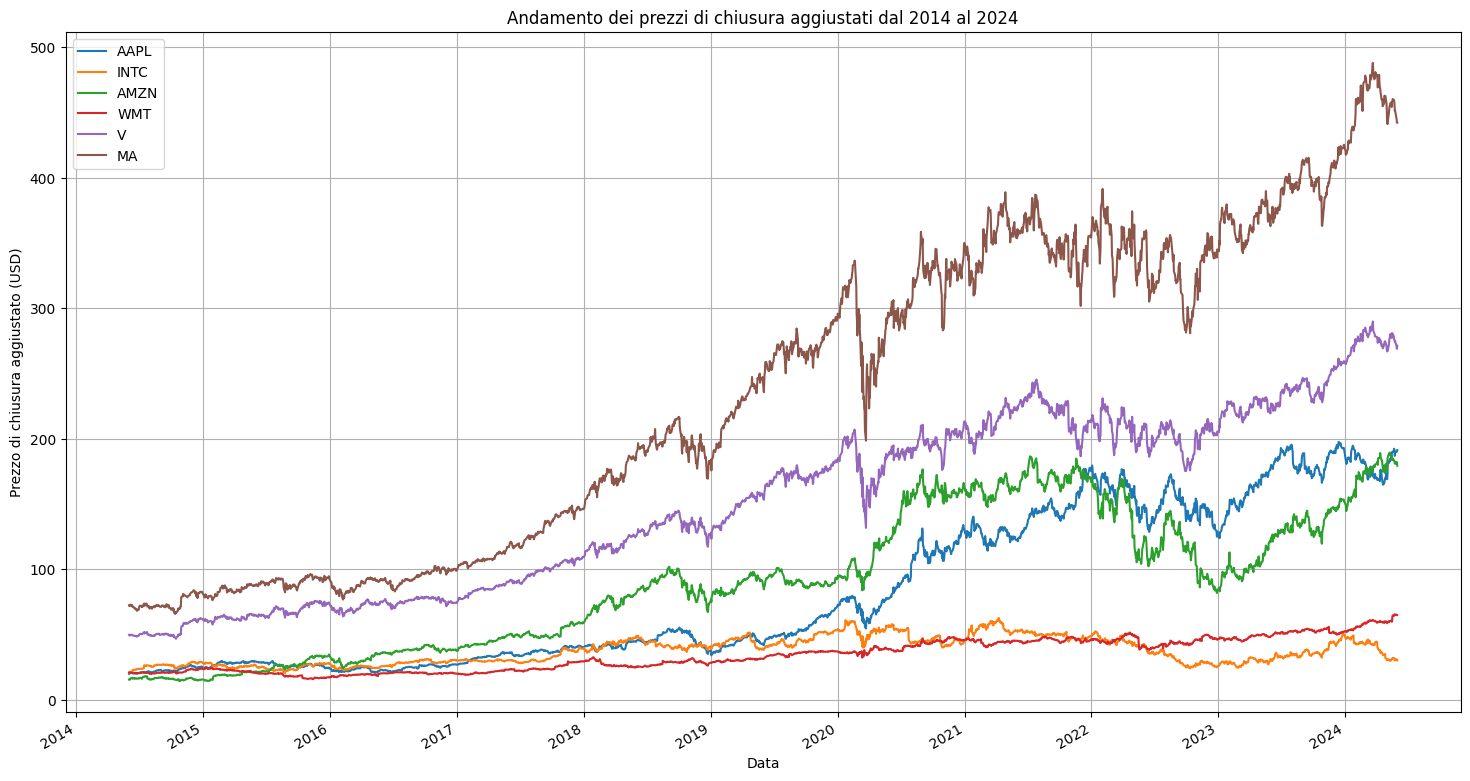

In [5]:
prezzi_chiusura_giornalieri.plot(figsize=(18, 10))
plt.title('Andamento dei prezzi di chiusura aggiustati dal 2014 al 2024')
plt.xlabel('Data')
plt.ylabel('Prezzo di chiusura aggiustato (USD)')
plt.legend()
plt.grid(True)
plt.show()

## 2. Statistiche descrittive

Calcoliamo il rendimento cumulato per ciascun titolo.

In primis definiamo una funzione che ci consenta di rappresentare i grafici di ciascun titolo in maniera separata, per evitare di fare confusione.

In [6]:
# Per creare i grafici utilizzo la mappa dei colori predefinita di matplotlib: in questo modo, ogni ticker mantiene il proprio colore nei diversi grafici
mappa_colori = plt.get_cmap('tab10') 

def crea_grafici_separati(dataframe, label):
    # Numero totale di grafici
    n = len(tickers)
    
    # Calcola il numero di righe necessarie
    rows = (n + 1) // 2
    
    # Crea una griglia di sottotrame
    fig, axes = plt.subplots(rows, 2, figsize=(18, 6 * rows))
    
    # Se c'è un numero dispari di grafici, disabilita l'ultima trama vuota
    if n % 2 != 0:
        axes[-1, -1].axis('off')
    
    # Itera attraverso i tickers e genera un grafico separato per ciascuno di essi
    for i, ticker in enumerate(tickers):
        ax = axes[i // 2, i % 2]
        
        # Seleziona solo i dati relativi al ticker corrente
        data = dataframe[ticker]

        # Crea il grafico
        ax.plot(data.index, data, label=ticker, color=mappa_colori(i))  
        ax.set_title(f'{ticker}')  
        ax.set_xlabel('Data')  
        ax.set_ylabel(label) 
        ax.legend() 
        ax.grid(True)

    plt.tight_layout()
    plt.show()

A partire dal DataFrame contenente i prezzi di chiusura giornalieri andiamo a ricavare i rendimenti netti e lordi.

In [7]:
# calcolo i rendimenti netti (come variazione di prezzo giornaliera) e rimuovo i NaN
rendimenti_netti_giornalieri = prezzi_chiusura_giornalieri.pct_change().dropna()
rendimenti_netti_giornalieri

Ticker,AAPL,INTC,AMZN,WMT,V,MA
Date,,,,,,
2014-06-03,0.014141,0.014673,-0.005343,-0.000651,-0.010303,-0.009085
2014-06-04,0.011419,-0.002169,-0.001335,0.005475,0.000521,-0.000393
2014-06-05,0.003924,0.002174,0.054730,0.002463,0.003736,0.006814
2014-06-06,-0.002750,0.018438,0.018852,-0.001423,0.003676,0.008199
2014-06-09,0.016001,-0.009230,-0.006582,-0.002590,-0.001972,-0.007874
...,...,...,...,...,...,...
2024-05-23,-0.021058,-0.042648,-0.011358,-0.006284,-0.004899,-0.011631
2024-05-24,0.016588,0.021277,-0.001657,0.008328,0.000948,-0.000066
2024-05-28,0.000053,0.011068,0.007745,-0.005200,-0.012787,-0.013520


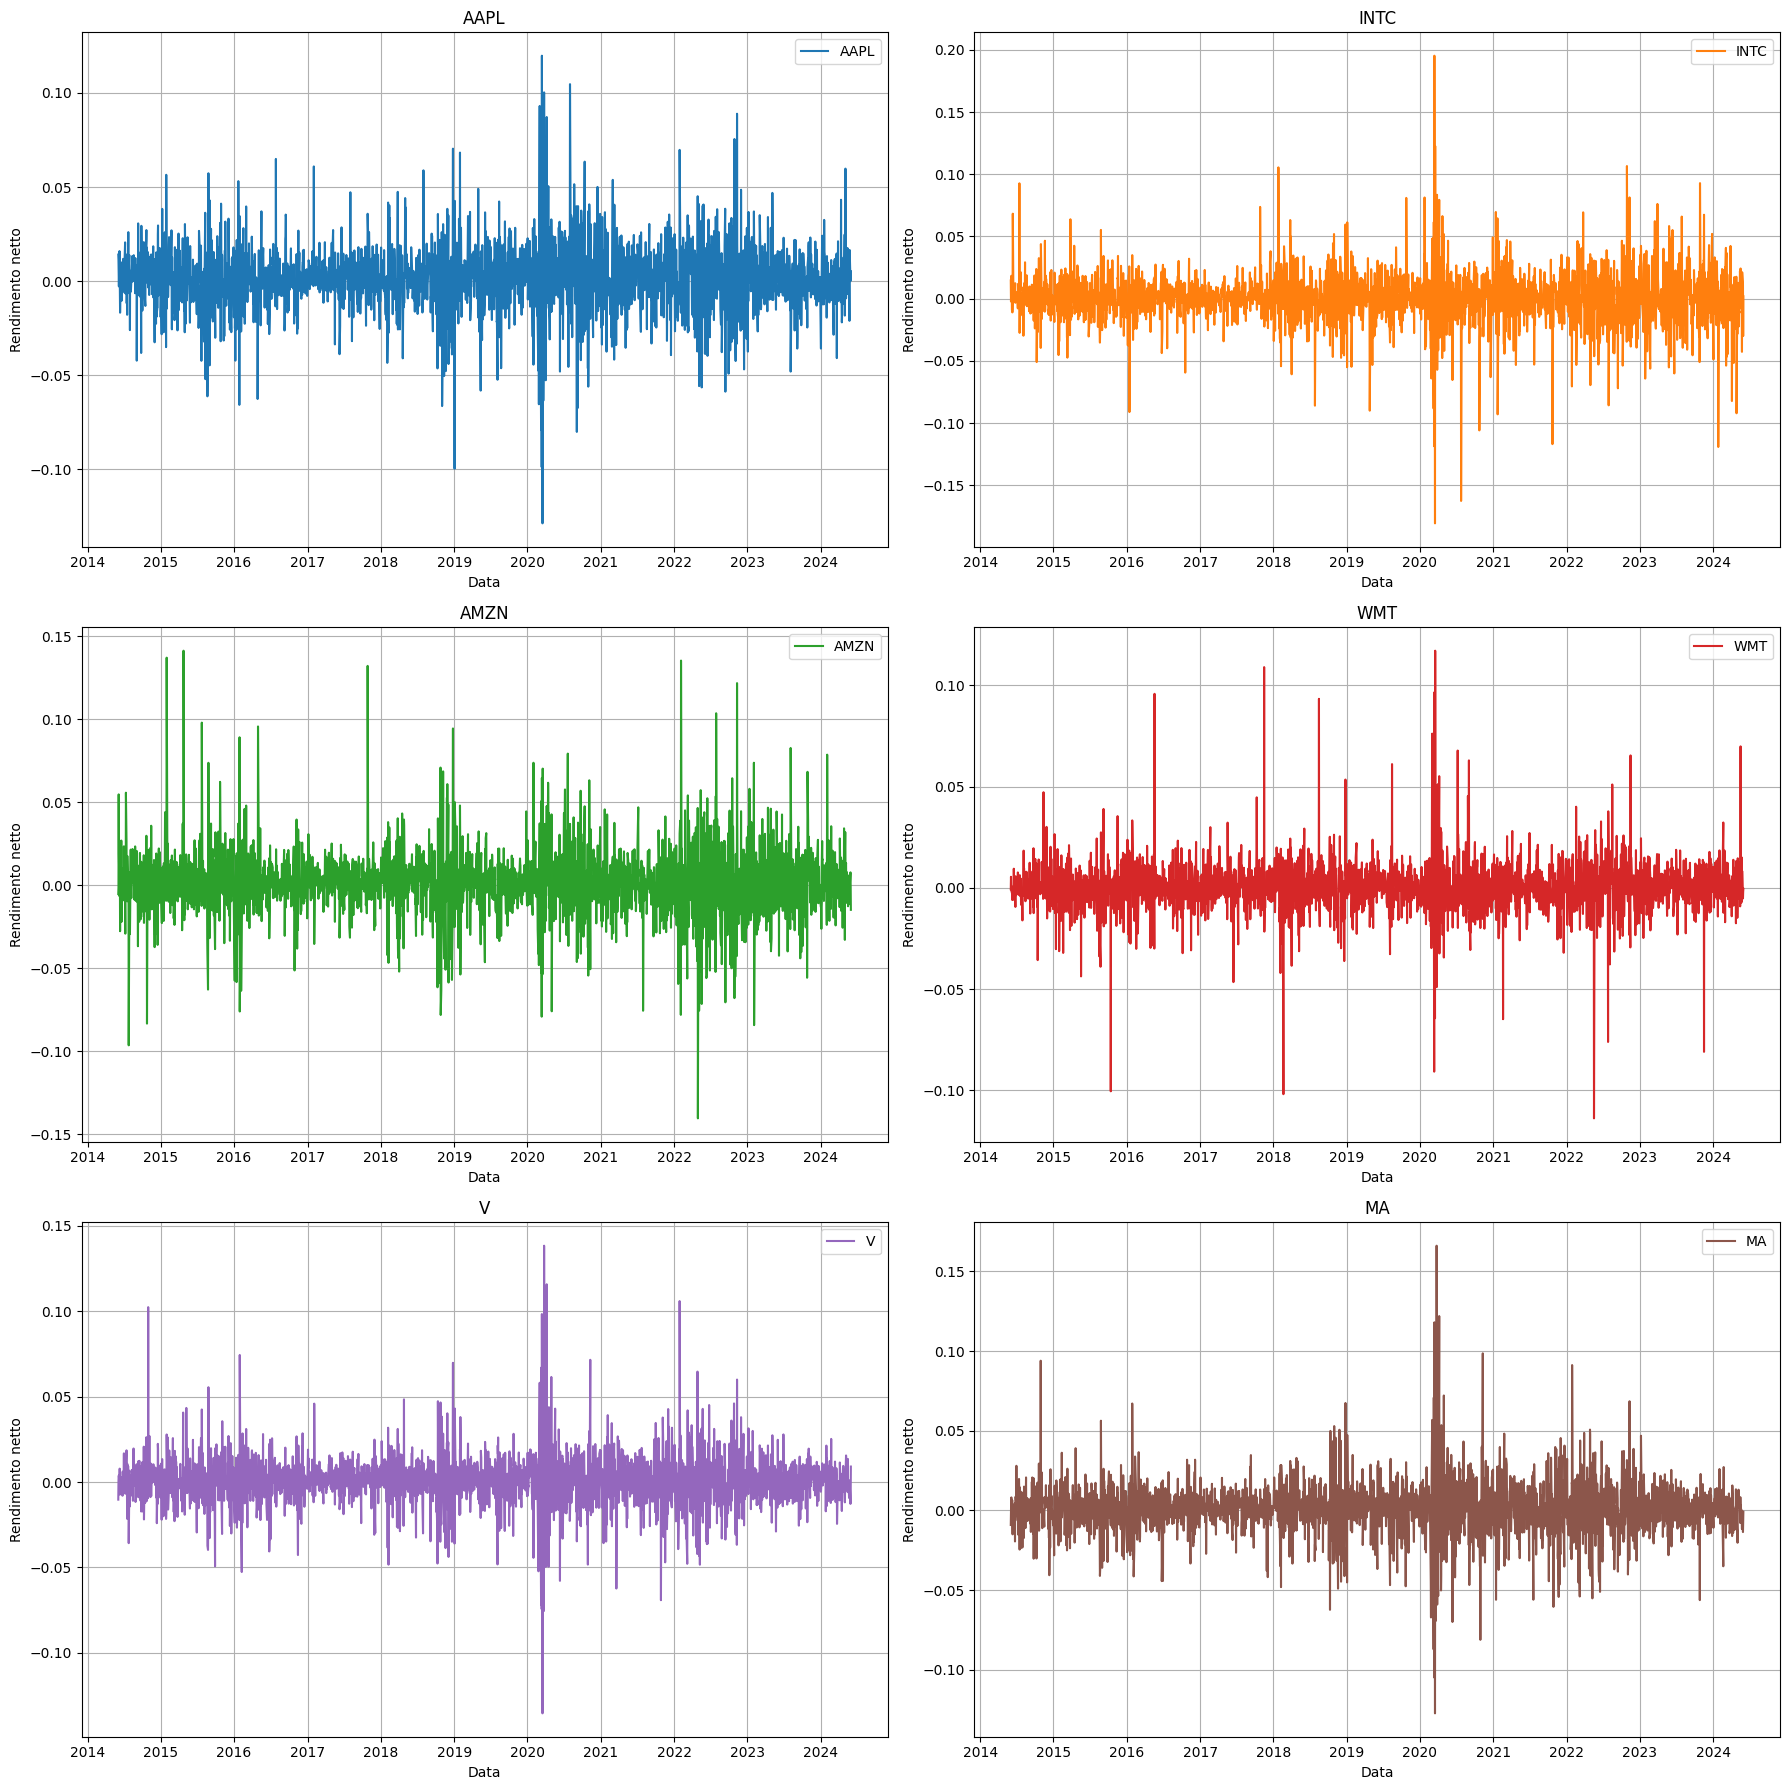

In [8]:
crea_grafici_separati(rendimenti_netti_giornalieri, 'Rendimento netto')

In [9]:
# ricavo i rendimenti lordi a partire da quelli netti
rendimenti_lordi_giornalieri = rendimenti_netti_giornalieri + 1
rendimenti_lordi_giornalieri

Ticker,AAPL,INTC,AMZN,WMT,V,MA
Date,,,,,,
2014-06-03,1.014141,1.014673,0.994657,0.999349,0.989697,0.990915
2014-06-04,1.011419,0.997831,0.998665,1.005475,1.000521,0.999607
2014-06-05,1.003924,1.002174,1.054730,1.002463,1.003736,1.006814
2014-06-06,0.997250,1.018438,1.018852,0.998577,1.003676,1.008199
2014-06-09,1.016001,0.990770,0.993418,0.997410,0.998028,0.992126
...,...,...,...,...,...,...
2024-05-23,0.978942,0.957352,0.988642,0.993716,0.995101,0.988369
2024-05-24,1.016588,1.021277,0.998343,1.008328,1.000948,0.999934
2024-05-28,1.000053,1.011068,1.007745,0.994800,0.987213,0.986480


In [10]:
# calcolo i rendimenti cumulati come prodotto cumulativo dei rendimenti lordi
rendimenti_cumulati = rendimenti_lordi_giornalieri.cumprod()

rendimenti_cumulati

Ticker,AAPL,INTC,AMZN,WMT,V,MA
Date,,,,,,
2014-06-03,1.014141,1.014673,0.994657,0.999349,0.989697,0.990915
2014-06-04,1.025722,1.012472,0.993330,1.004820,0.990212,0.990525
2014-06-05,1.029747,1.014673,1.047695,1.007295,0.993911,0.997275
2014-06-06,1.026915,1.033382,1.067446,1.005862,0.997565,1.005451
2014-06-09,1.043347,1.023844,1.060420,1.003257,0.995598,0.997534
...,...,...,...,...,...,...
2024-05-23,9.410157,1.442240,11.724517,3.117381,5.509322,6.228435
2024-05-24,9.566254,1.472926,11.705090,3.143343,5.514545,6.228021
2024-05-28,9.566758,1.489228,11.795751,3.126997,5.444029,6.143817


Visualizziamo l'andamento dei rendimenti cumulati nel corso del tempo.

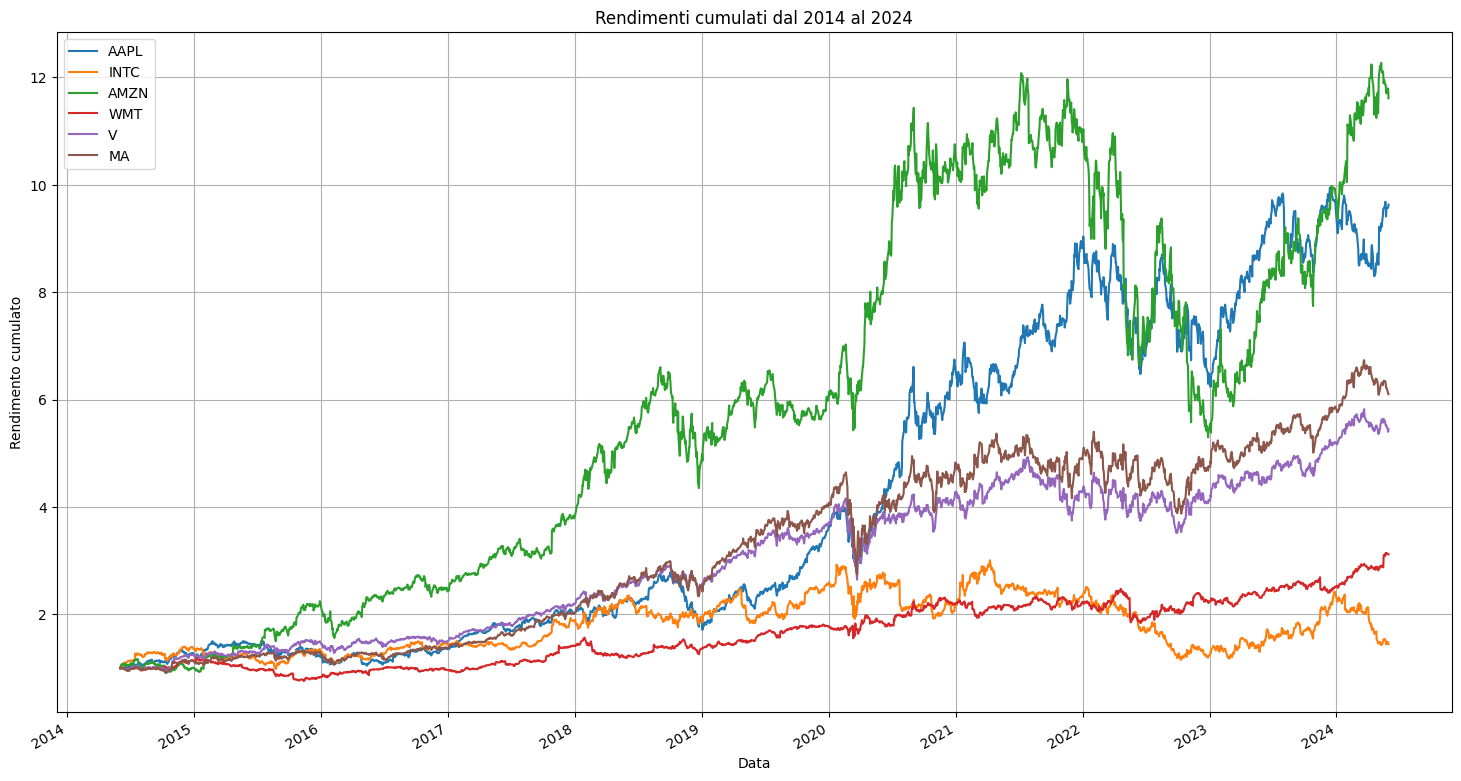

In [11]:
rendimenti_cumulati.plot(figsize=(18, 10))
plt.title('Rendimenti cumulati dal 2014 al 2024')
plt.xlabel('Data')
plt.ylabel('Rendimento cumulato')
plt.legend()
plt.grid(True)
plt.show()

Analogamente, visualizziamo l'evoluzione della volatilità nel tempo.

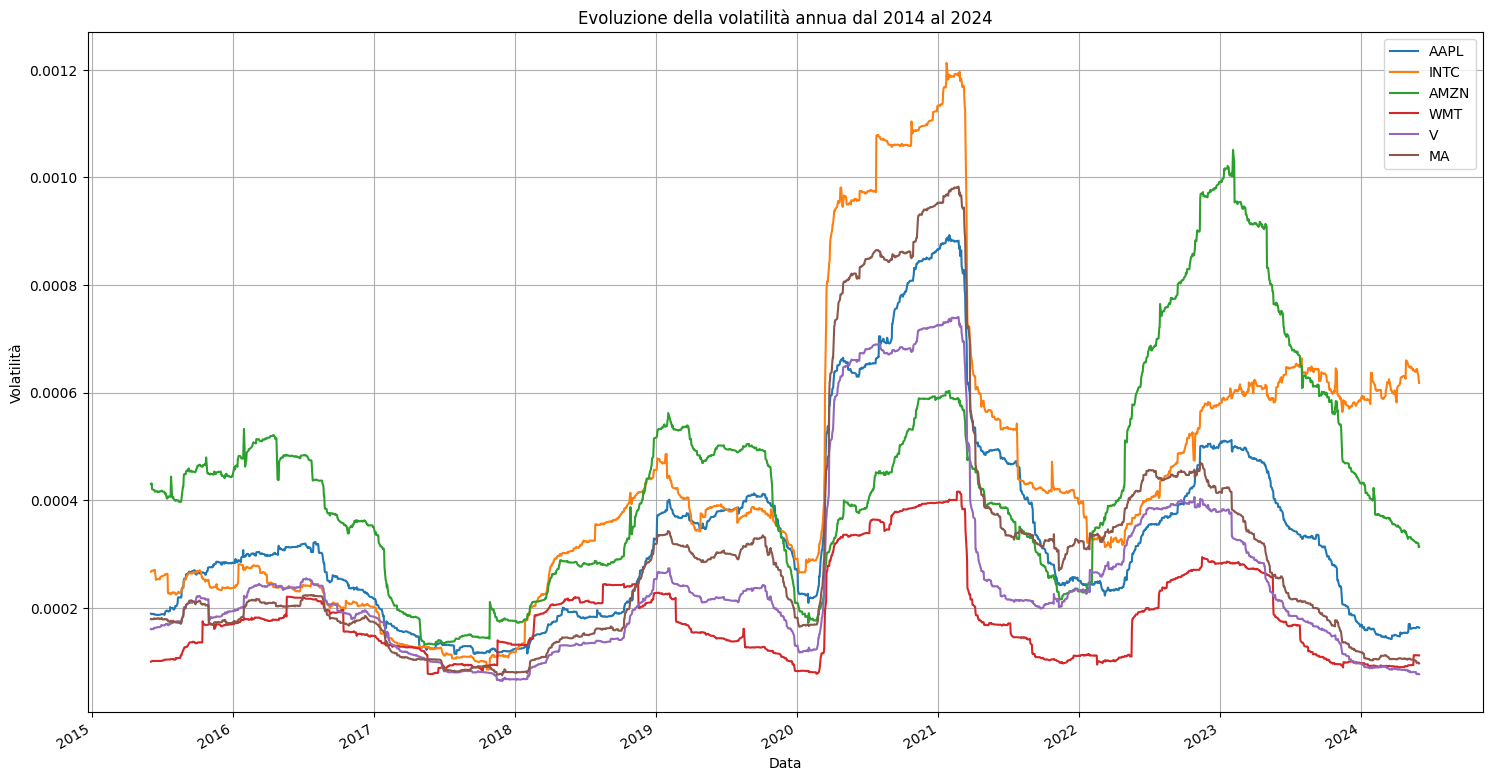

In [12]:
rendimenti_netti_giornalieri.rolling(window=252).var().plot(figsize=(18, 10))
plt.title('Evoluzione della volatilità annua dal 2014 al 2024')
plt.xlabel('Data')
plt.ylabel('Volatilità')
plt.legend()
plt.grid(True)
plt.show()

Ora calcoliamo il rendimento composto annuo sul periodo considerato (Compound Annual Growth Rate, CAGR).

In [13]:
numero_anni = (fine - inizio) / dt.timedelta(days=365)
CAGR = rendimenti_cumulati.iloc[-1] ** (1 / numero_anni) - 1 # sfrutto i rendimenti cumulati che ho già calcolato
CAGR.rename("CAGR", inplace=True)

CAGR

Ticker
AAPL    0.253984
INTC    0.037646
AMZN    0.277630
WMT     0.120397
V       0.184630
MA      0.198085
Name: CAGR, dtype: float64

A partire dai rendimenti lordi giornalieri ricaviamo i rendimenti logaritmici.

In [14]:
rendimenti_logaritmici = np.log(rendimenti_lordi_giornalieri) # i rendimenti lordi li ho calcolati in precedenza
rendimenti_logaritmici

Ticker,AAPL,INTC,AMZN,WMT,V,MA
Date,,,,,,
2014-06-03,0.014042,0.014567,-0.005357,-0.000652,-0.010357,-0.009126
2014-06-04,0.011355,-0.002172,-0.001336,0.005460,0.000520,-0.000394
2014-06-05,0.003916,0.002172,0.053285,0.002460,0.003729,0.006791
2014-06-06,-0.002754,0.018270,0.018677,-0.001424,0.003669,0.008166
2014-06-09,0.015875,-0.009273,-0.006604,-0.002594,-0.001974,-0.007905
...,...,...,...,...,...,...
2024-05-23,-0.021283,-0.043584,-0.011423,-0.006303,-0.004911,-0.011700
2024-05-24,0.016452,0.021053,-0.001658,0.008294,0.000948,-0.000066
2024-05-28,0.000053,0.011007,0.007716,-0.005214,-0.012870,-0.013612


Vediamo il livello di correlazione che sussiste tra i rendimenti dei titoli appartenenti allo stesso settore.

In [15]:
rendimenti_netti_giornalieri[tickers_settore1].corr()

Ticker,AAPL,INTC
Ticker,,
AAPL,1.000000,0.512799
INTC,0.512799,1.000000


In [16]:
rendimenti_netti_giornalieri[tickers_settore2].corr()

Ticker,AMZN,WMT
Ticker,,
AMZN,1.000000,0.250431
WMT,0.250431,1.000000


In [17]:
rendimenti_netti_giornalieri[tickers_settore3].corr()

Ticker,V,MA
Ticker,,
V,1.000000,0.895385
MA,0.895385,1.000000


Visualizziamo come i rendimenti sono distribuiti attraverso degli istogrammi. 

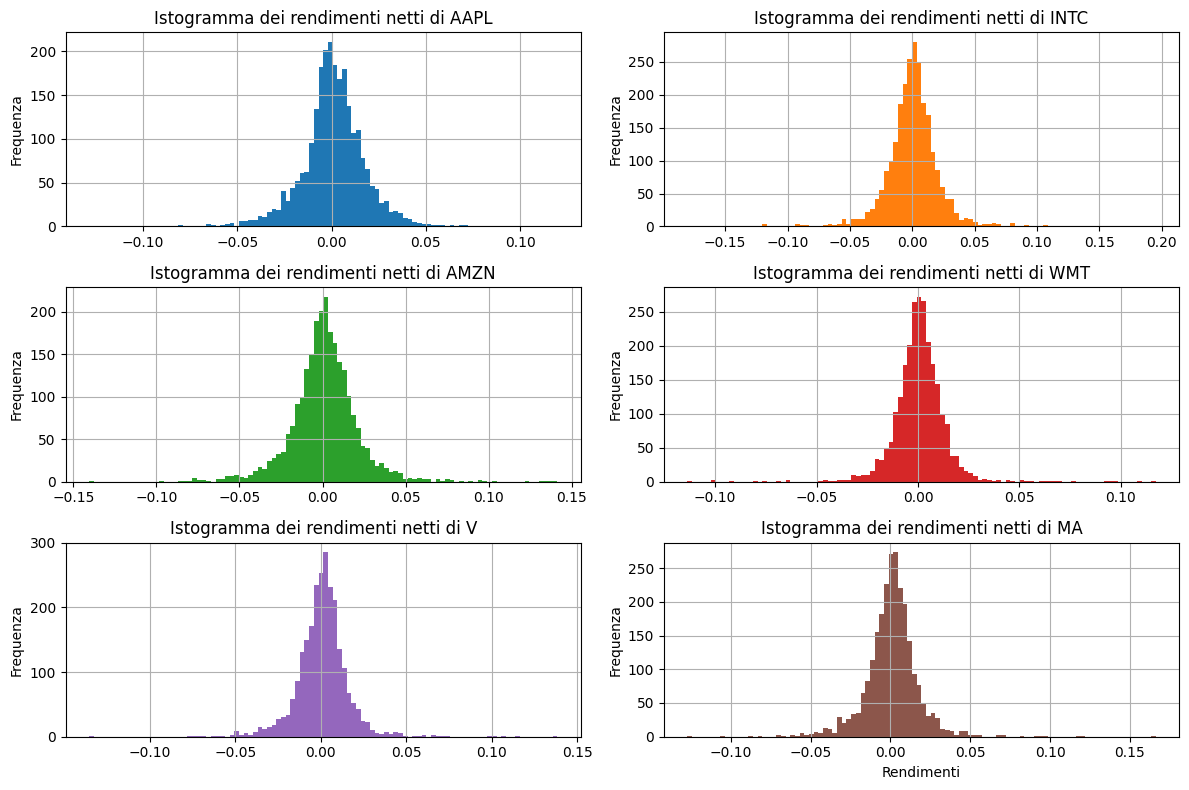

In [18]:
# Numero di colonne per la disposizione degli istogrammi
num_cols = 2
num_rows = int(len(tickers) / num_cols)

# Creazione della figura con sottotrame
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

# Appiattire gli assi in caso di array bidimensionale
axes = axes.flatten()

# Creazione degli istogrammi con colori personalizzati
for i, ticker in enumerate(tickers):
    color = mappa_colori(i % 10)  # Usa il modulo per assicurarsi di non superare l'indice dei colori disponibili
    rendimenti_netti_giornalieri[ticker].hist(bins=100, ax=axes[i], color=color)
    axes[i].set_title(f'Istogramma dei rendimenti netti di {ticker}')
    axes[i].set_ylabel('Frequenza')

# Rimuovere assi vuoti
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.xlabel('Rendimenti')
plt.tight_layout()
plt.show()

Per ciascun titolo visualizziamo i grafici diagnostici a tre sezioni.

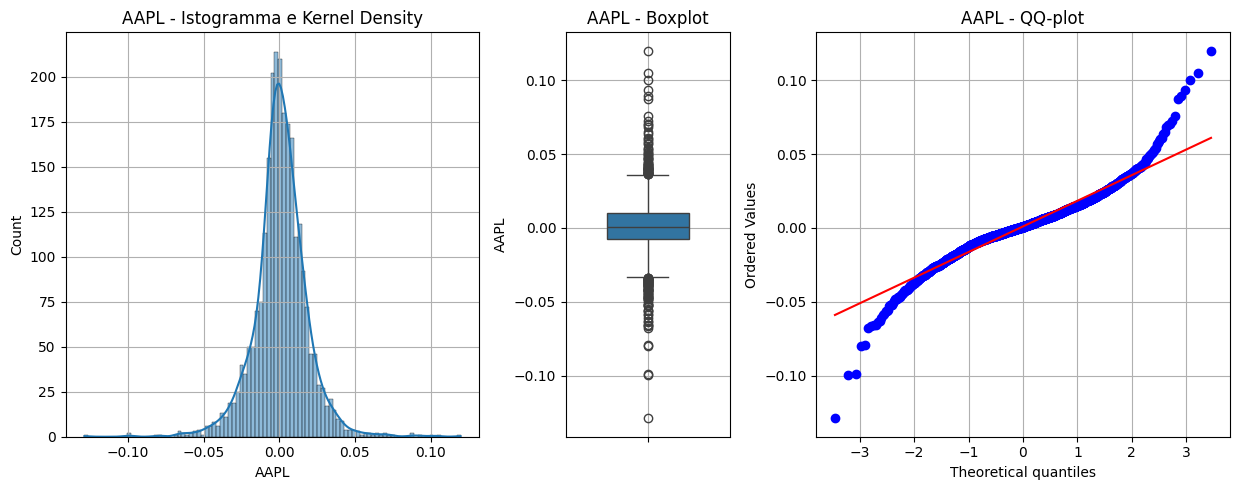

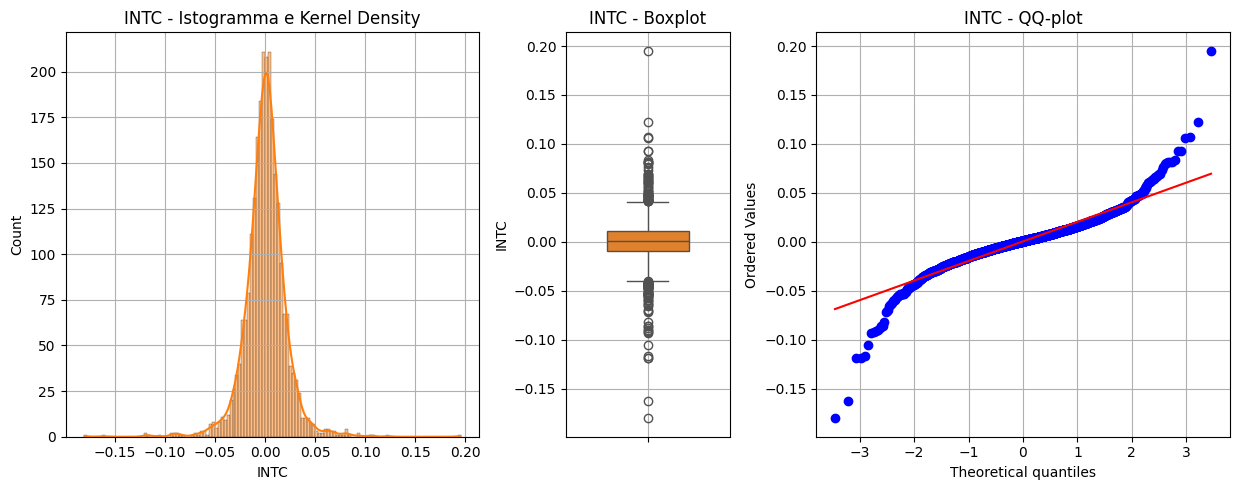

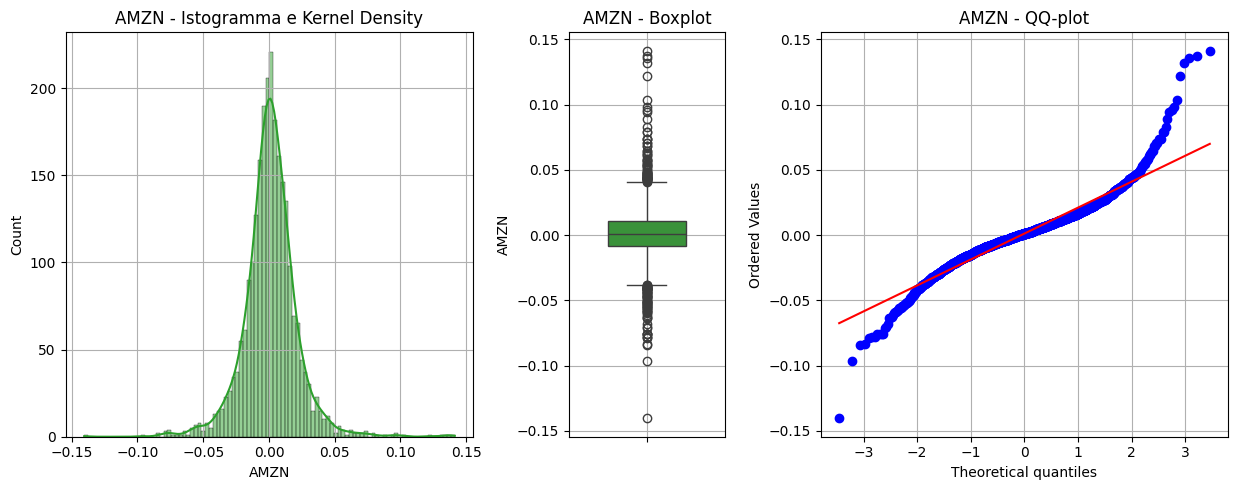

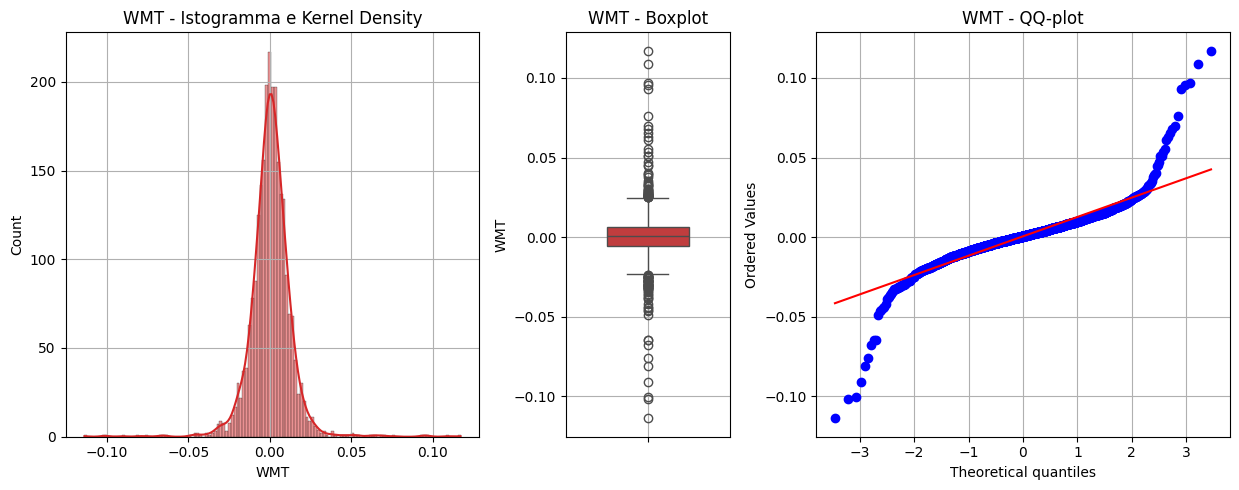

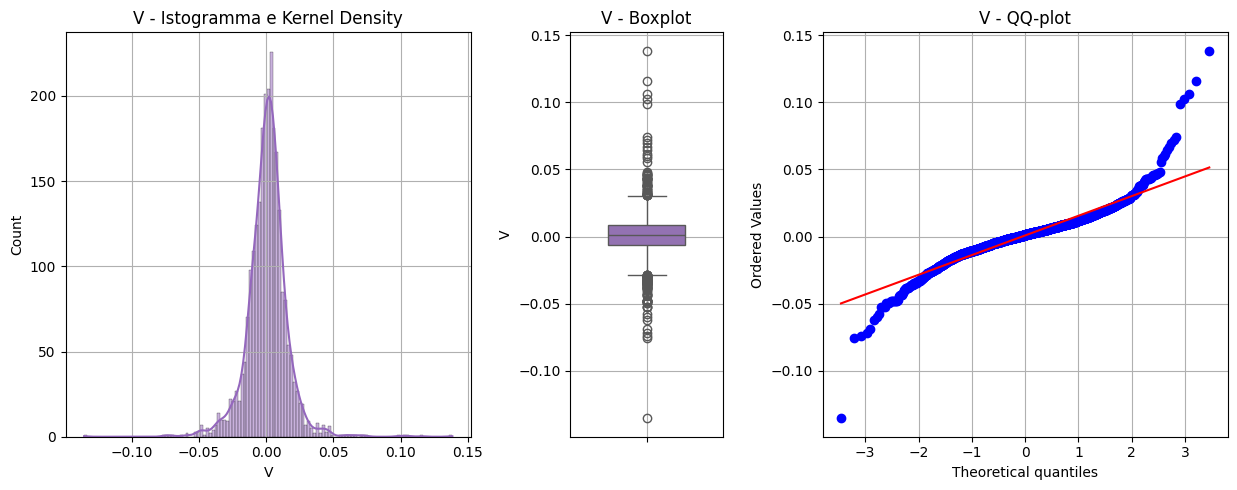

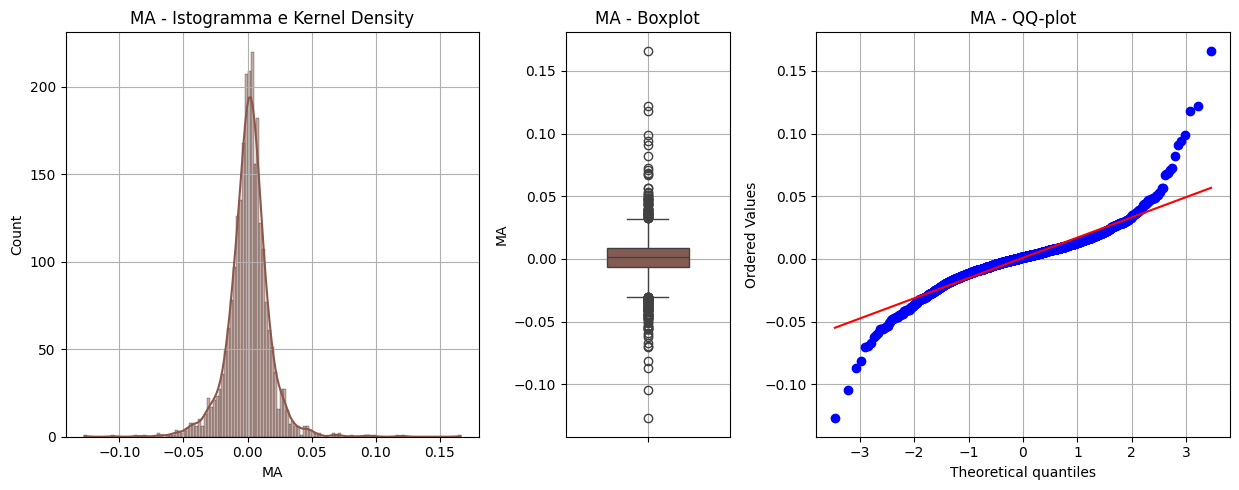

In [19]:
def crea_grafici_diagnostici(dataframe, ticker, colore):
    plt.figure(figsize=(15, 5))

    # Istogramma e kernel density
    plt.subplot2grid((1, 6), (0, 0), colspan=2, rowspan=1)
    sns.histplot(data=dataframe[ticker], kde=True, color=colore)
    plt.title(f'{ticker} - Istogramma e Kernel Density')
    plt.grid(True)

    # Boxplot
    plt.subplot2grid((1, 6), (0, 2), colspan=1, rowspan=1)
    sns.boxplot(data=dataframe[ticker], color=colore, width=0.5)
    plt.title(f'{ticker} - Boxplot')
    plt.grid(True)

    # QQ-plot
    plt.subplot2grid((1, 6), (0, 3), colspan=2, rowspan=1)
    stats.probplot(dataframe[ticker], dist="norm", plot=plt)
    plt.title(f'{ticker} - QQ-plot')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Esegui la funzione per ciascun titolo
for i, ticker in enumerate(tickers):
    colore = mappa_colori(i % 10)  # L'operazione modulo assicura che non superiamo l'indice massimo della mappa
    crea_grafici_diagnostici(rendimenti_netti_giornalieri, ticker, colore)

Calcoliamo le statistiche descrittive univariate dei rendimenti netti giornalieri.

In [20]:
statistiche_rendimenti_netti_giornalieri = rendimenti_netti_giornalieri.describe()

varianza = pd.Series(rendimenti_netti_giornalieri.var()).to_frame().T
kurtosi = pd.Series(rendimenti_netti_giornalieri.kurtosis()).to_frame().T
skewness = pd.Series(rendimenti_netti_giornalieri.skew()).to_frame().T
varianza.rename(index={0: 'var'}, inplace=True)
kurtosi.rename(index={0: 'kurt'}, inplace=True)
skewness.rename(index={0: 'skew'}, inplace=True)

statistiche_rendimenti_netti_giornalieri = pd.concat([statistiche_rendimenti_netti_giornalieri, varianza])
statistiche_rendimenti_netti_giornalieri = pd.concat([statistiche_rendimenti_netti_giornalieri, kurtosi])
statistiche_rendimenti_netti_giornalieri = pd.concat([statistiche_rendimenti_netti_giornalieri, skewness])

statistiche_rendimenti_netti_giornalieri

Ticker,AAPL,INTC,AMZN,WMT,V,MA
count,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000
mean,0.001060,0.000370,0.001187,0.000539,0.000793,0.000863
std,0.017841,0.021046,0.020638,0.013181,0.015427,0.016970
min,-0.128647,-0.180415,-0.140494,-0.113758,-0.135472,-0.127255
25%,-0.007315,-0.009571,-0.008609,-0.005382,-0.006481,-0.006842
50%,0.000821,0.000795,0.001153,0.000576,0.001316,0.001395
75%,0.010141,0.010663,0.011145,0.006606,0.008235,0.008719
max,0.119808,0.195213,0.141311,0.117085,0.138427,0.166109
var,0.000318,0.000443,0.000426,0.000174,0.000238,0.000288
kurt,5.360845,10.311218,6.337522,16.261172,10.399232,10.021940


Ora vediamo la matrice di covarianza e la matrice di correlazione.

In [21]:
rendimenti_netti_giornalieri.cov() # matrice di covarianza

Ticker,AAPL,INTC,AMZN,WMT,V,MA
Ticker,,,,,,
AAPL,0.000318,0.000193,0.000203,0.000075,0.000158,0.000178
INTC,0.000193,0.000443,0.000173,0.000076,0.000150,0.000169
AMZN,0.000203,0.000173,0.000426,0.000068,0.000149,0.000169
WMT,0.000075,0.000076,0.000068,0.000174,0.000059,0.000064
V,0.000158,0.000150,0.000149,0.000059,0.000238,0.000234
MA,0.000178,0.000169,0.000169,0.000064,0.000234,0.000288


In [22]:
rendimenti_netti_giornalieri.corr() # matrice di correlazione

Ticker,AAPL,INTC,AMZN,WMT,V,MA
Ticker,,,,,,
AAPL,1.000000,0.512799,0.551232,0.320545,0.572280,0.586874
INTC,0.512799,1.000000,0.397253,0.274462,0.461147,0.474221
AMZN,0.551232,0.397253,1.000000,0.250431,0.466579,0.483197
WMT,0.320545,0.274462,0.250431,1.000000,0.289393,0.284192
V,0.572280,0.461147,0.466579,0.289393,1.000000,0.895385
MA,0.586874,0.474221,0.483197,0.284192,0.895385,1.000000


Vediamo com'è stato l'andamento nel tempo della correlazione tra titoli dello stesso settore.

In [23]:
def andamento_correlazione_rendimenti(tickers_settore, nome_settore, colore):
    # Calcola la correlazione tra i titoli del settore
    correlazione = rendimenti_netti_giornalieri[tickers_settore[0]].rolling(window=252).corr(rendimenti_netti_giornalieri[tickers_settore[1]])

    # Plot
    fig, ax = plt.subplots(figsize=(12, 6))
    correlazione.plot(label=nome_settore, ax=ax, color=colore)

    ax.axhline(rendimenti_netti_giornalieri.corr().loc[tickers_settore[0], tickers_settore[1]], c='r')
    plt.legend()
    plt.title(f'Andamento della correlazione nel tempo dei titoli per il settore {nome_settore}')
    plt.xlabel('Data')
    plt.ylabel('Correlazione')
    plt.grid(True)
    plt.show()

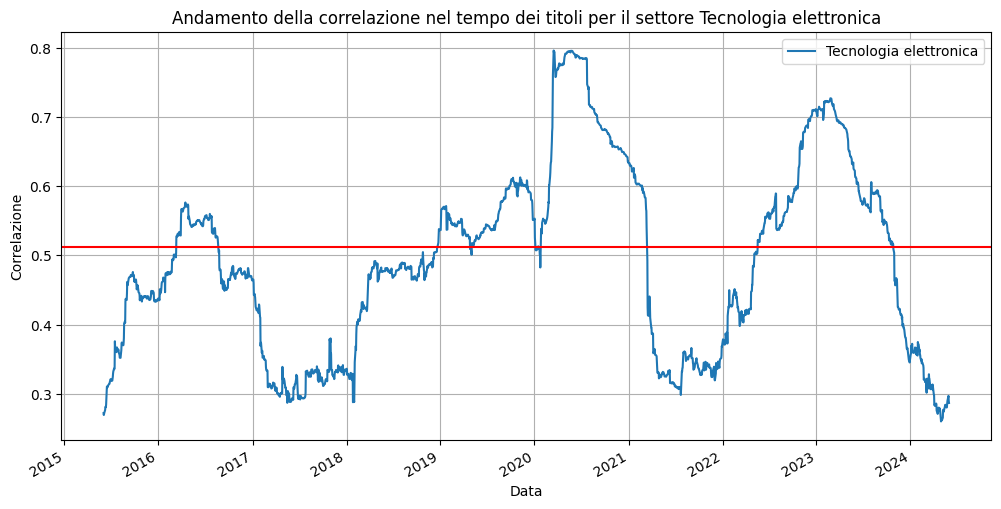

In [24]:
andamento_correlazione_rendimenti(tickers_settore1, settore_1, mappa_colori(0))

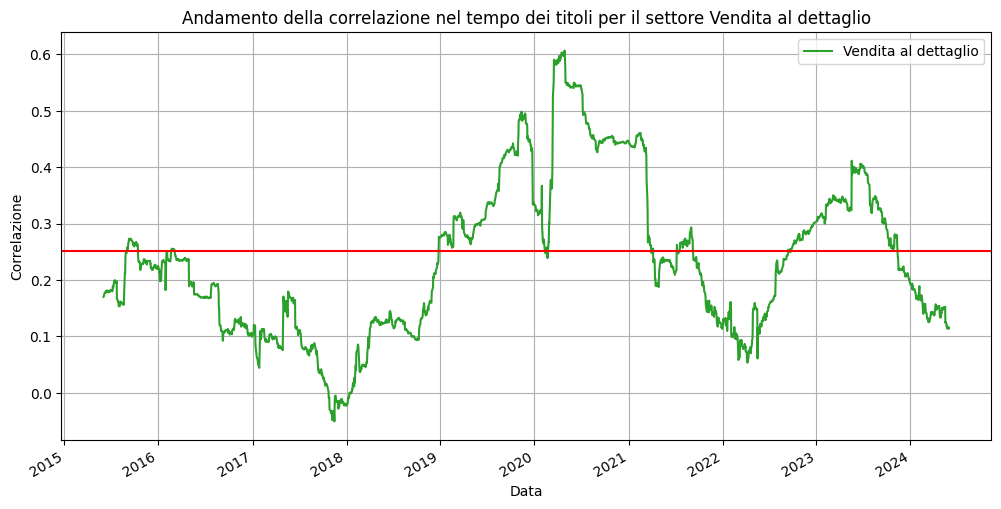

In [25]:
andamento_correlazione_rendimenti(tickers_settore2, settore_2, mappa_colori(2))

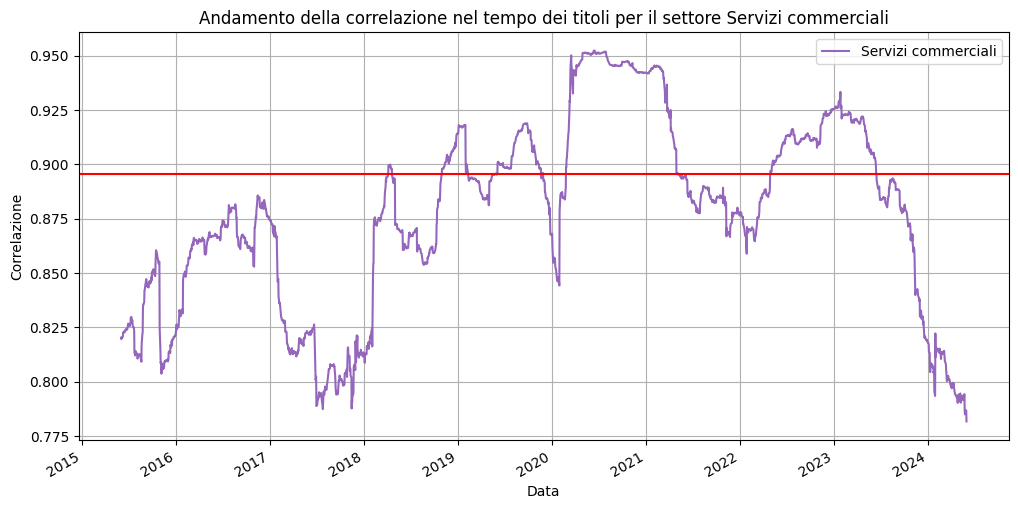

In [26]:
andamento_correlazione_rendimenti(tickers_settore3, settore_3, mappa_colori(4))

Attraverso degli scatter plot osserviamo la dispersione dei rendimenti mettendo a confronto i titoli dello stesso settore. 

In [27]:
colore_neutro_chiaro = '#333333'
colore_neutro_scuro = '#666666'
def crea_scatter_plot(dataframe, settore):
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(1,1,1)
    ax.scatter(dataframe[settore[0]], dataframe[settore[1]], color=colore_neutro_chiaro)
    ax.set_xlim(min(dataframe[settore[0]]), max(dataframe[settore[1]]))
    ax.autoscale(False)
    ax.vlines(0, -10, 10, color=colore_neutro_scuro)
    ax.hlines(0, -10, 10, color=colore_neutro_scuro)
    ax.plot((-10,10),(-10,10), color=colore_neutro_scuro)
    ax.set_xlabel(settore[0])
    ax.set_ylabel(settore[1])
    plt.grid(True)

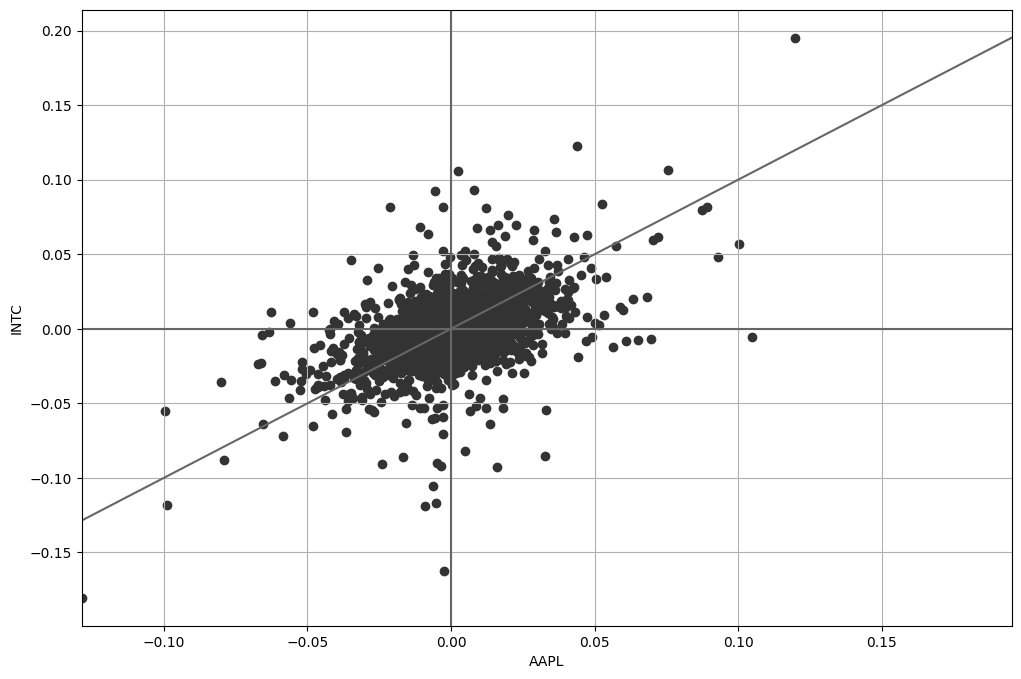

In [28]:
crea_scatter_plot(rendimenti_netti_giornalieri, tickers_settore1)

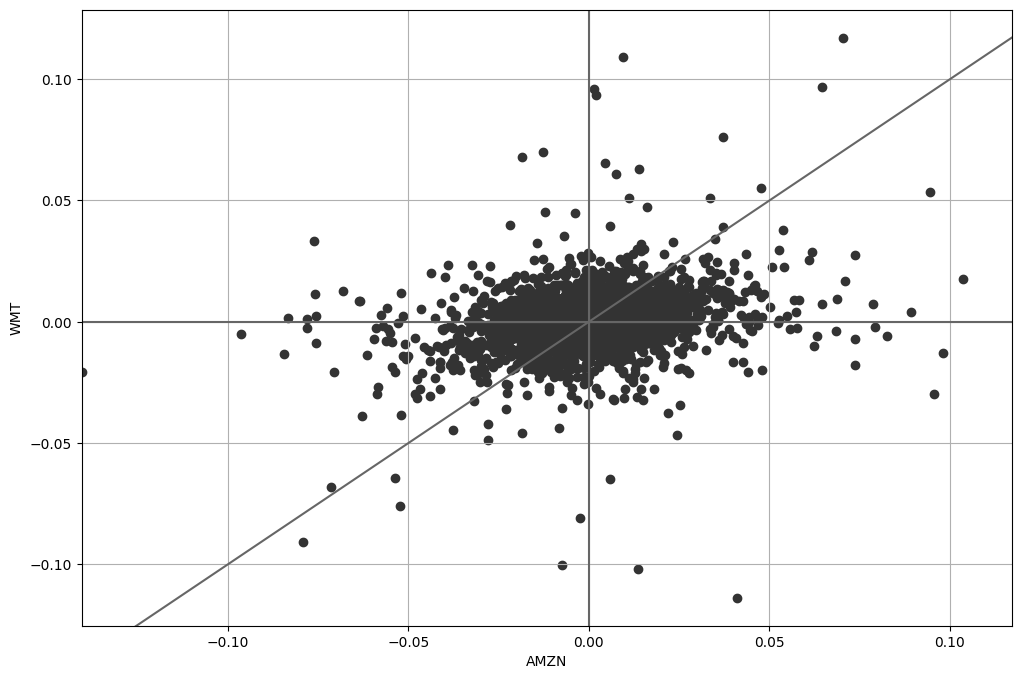

In [29]:
crea_scatter_plot(rendimenti_netti_giornalieri, tickers_settore2)

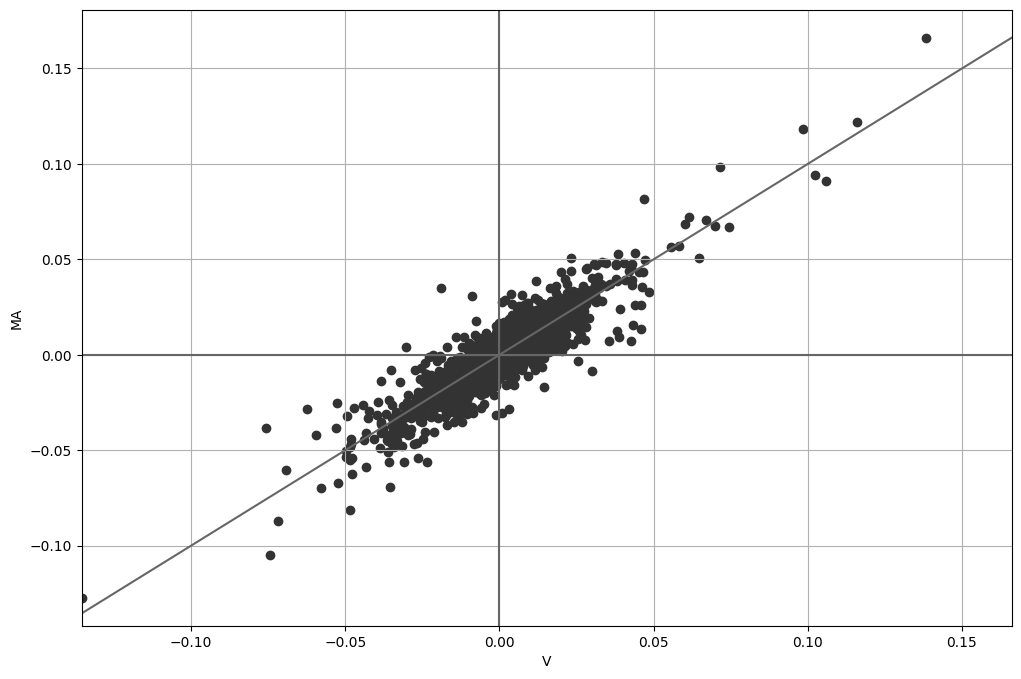

In [30]:
crea_scatter_plot(rendimenti_netti_giornalieri, tickers_settore3)

## Strategie di trading e backtesting

Procediamo ora con la costruzione di una strategia di trading. <br>
L'idea che si vuole analizzare è quella di combinare l'utilizzo delle medie mobili esponenziali e dell'indice RSI per generare segnali d'acquisto: utilizzando entrambi gli indicatori è possibile tenere conto sia del trend (catturato dalle medie mobili esponenziali) sia del momentum (catturato dall'indice RSI).

In [31]:
ticker_strategia = 'MA'
indicatori_trading  = prezzi_chiusura_giornalieri[ticker_strategia].copy()
indicatori_trading.rename('Chiusura aggiustata', inplace=True)
indicatori_trading = indicatori_trading.to_frame()

indicatori_trading['EMA20'] = indicatori_trading['Chiusura aggiustata'].ewm(span=20, adjust=False).mean() # calcolo la media mobile esponenziale a 20 giorni
indicatori_trading['EMA50'] = indicatori_trading['Chiusura aggiustata'].ewm(span=50, adjust=False).mean() # calcolo la media mobile esponenziale a 50 giorni

In [32]:
def calcola_RSI(data, window=14):
    delta = data['Chiusura aggiustata'].diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    RS = gain / loss
    RSI = 100 - (100 / (1 + RS))
    return RSI

indicatori_trading['RSI'] = calcola_RSI(indicatori_trading) # calcolo l'indice RSI
indicatori_trading.dropna(inplace=True)

indicatori_trading

,Chiusura aggiustata,EMA20,EMA50,RSI
Date,,,,
2014-06-19,69.829750,71.584129,72.034409,29.559017
2014-06-20,69.397247,71.375855,71.930991,27.686140
2014-06-23,69.707550,71.216969,71.843797,33.962617
2014-06-24,68.353638,70.944270,71.706928,28.193291
2014-06-25,68.673302,70.727988,71.587962,26.601205
...,...,...,...,...
2024-05-23,451.209991,456.752035,458.953742,61.606337
2024-05-24,451.179993,456.221364,458.648889,53.338249
2024-05-28,445.079987,455.160281,458.116776,36.483716


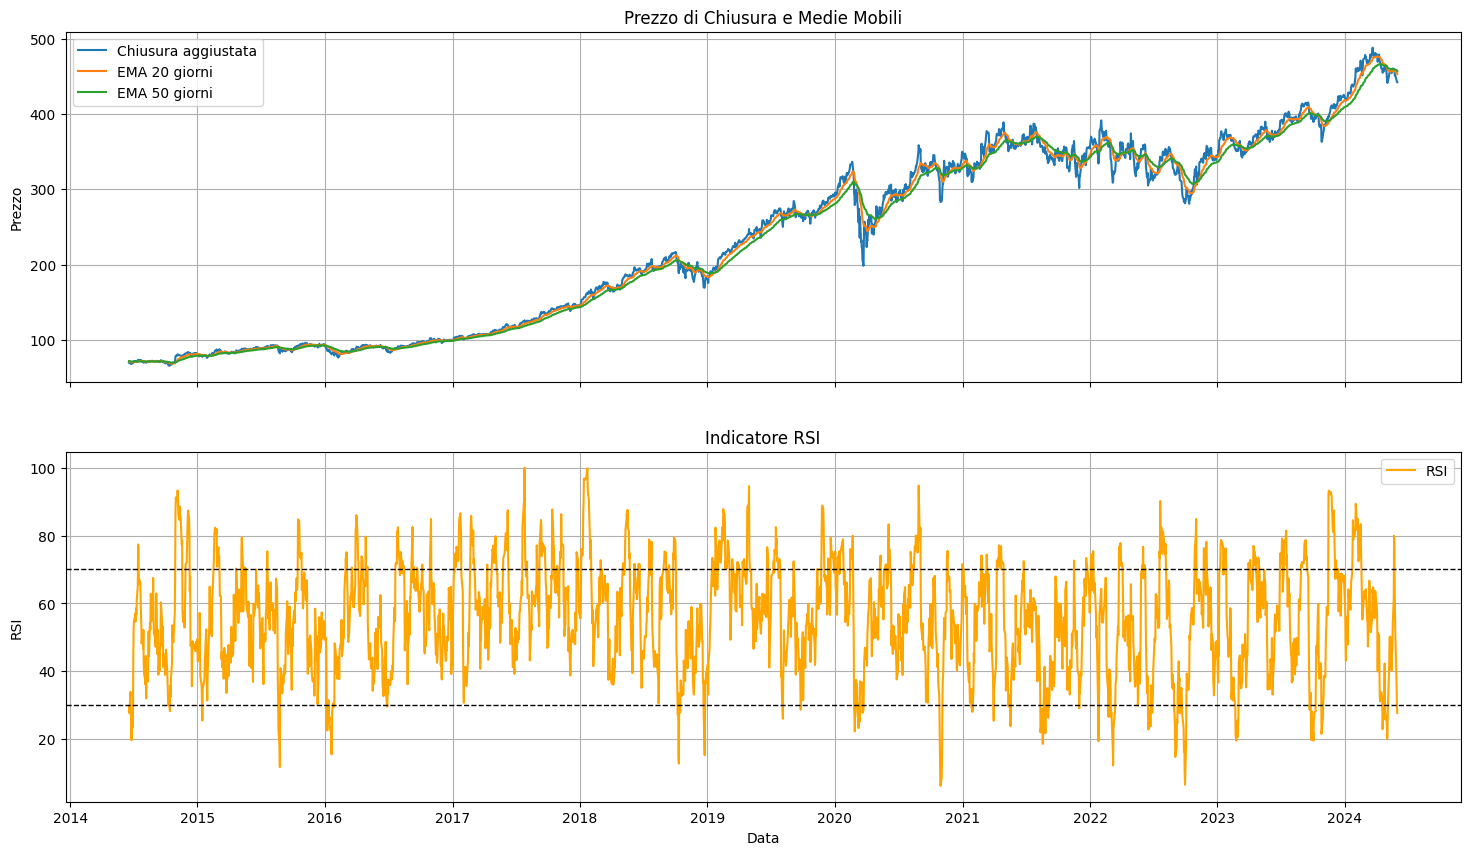

In [33]:
# Creazione dei grafici
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 10), sharex=True)

# Grafico del prezzo di chiusura e delle medie mobili
ax1.plot(indicatori_trading.index, indicatori_trading['Chiusura aggiustata'], label='Chiusura aggiustata')
ax1.plot(indicatori_trading.index, indicatori_trading['EMA20'], label='EMA 20 giorni')
ax1.plot(indicatori_trading.index, indicatori_trading['EMA50'], label='EMA 50 giorni')
ax1.set_title('Prezzo di Chiusura e Medie Mobili')
ax1.set_ylabel('Prezzo')
ax1.legend()
ax1.grid(True)

# Grafico dell'indicatore RSI
ax2.plot(indicatori_trading.index, indicatori_trading['RSI'], label='RSI', color='orange')
ax2.axhline(70, color='black', linestyle='--', linewidth=1)
ax2.axhline(30, color='black', linestyle='--', linewidth=1)
ax2.set_title('Indicatore RSI')
ax2.set_ylabel('RSI')
ax2.set_xlabel('Data')
ax2.legend()
ax2.grid(True)

plt.show()

Dopo aver calcolato gli indicatori di cui abbiamo bisogno, procediamo con l'applicazione della strategia.

Secondo la strategia viene generato un __segnale di acquisto__ quando le seguenti condizioni sono soddisfatte:
- la media mobile esponenziale a breve termine (20 giorni) sorpassa dal basso verso l'alto la media mobile esponenziale a lungo termine (50 giorni), testimoniando un trend al rialzo
- l'indice RSI supera 50, confermando che il trend rialzista è abbastanza intenso

Secondo la strategia viene generato un __segnale di vendita__ quando le seguenti condizioni sono soddisfatte:
- la media mobile esponenziale a breve termine (20 giorni) sorpassa dall'alto verso il basso la media mobile esponenziale a lungo termine (50 giorni), testimoniando un trend al ribasso
- l'indice RSI scende sotto 50, confermando che il trend ribassista è abbastanza intenso

In [34]:
strategia_trading = indicatori_trading.copy()

condizione_acquisto = ((strategia_trading['EMA20'] > strategia_trading['EMA50']) &
                       (strategia_trading['RSI'] > 50))
                      
condizione_vendita = ((strategia_trading['EMA20'] < strategia_trading['EMA50']) &
                      (strategia_trading['RSI'] < 50))

# Crea la colonna "Posizione" e assegna i valori in base alle condizioni
strategia_trading['Posizione'] = 0  # Inizializza tutte le posizioni a 0

# Imposta le posizioni a 1 quando si verifica la condizione di acquisto
strategia_trading.loc[condizione_acquisto, 'Posizione'] = 1

# Imposta le posizioni a 1 quando si verifica la condizione di vendita
strategia_trading.loc[condizione_vendita, 'Posizione'] = 0

strategia_trading

,Chiusura aggiustata,EMA20,EMA50,RSI,Posizione
Date,,,,,
2014-06-19,69.829750,71.584129,72.034409,29.559017,0
2014-06-20,69.397247,71.375855,71.930991,27.686140,0
2014-06-23,69.707550,71.216969,71.843797,33.962617,0
2014-06-24,68.353638,70.944270,71.706928,28.193291,0
2014-06-25,68.673302,70.727988,71.587962,26.601205,0
...,...,...,...,...,...
2024-05-23,451.209991,456.752035,458.953742,61.606337,0
2024-05-24,451.179993,456.221364,458.648889,53.338249,0
2024-05-28,445.079987,455.160281,458.116776,36.483716,0


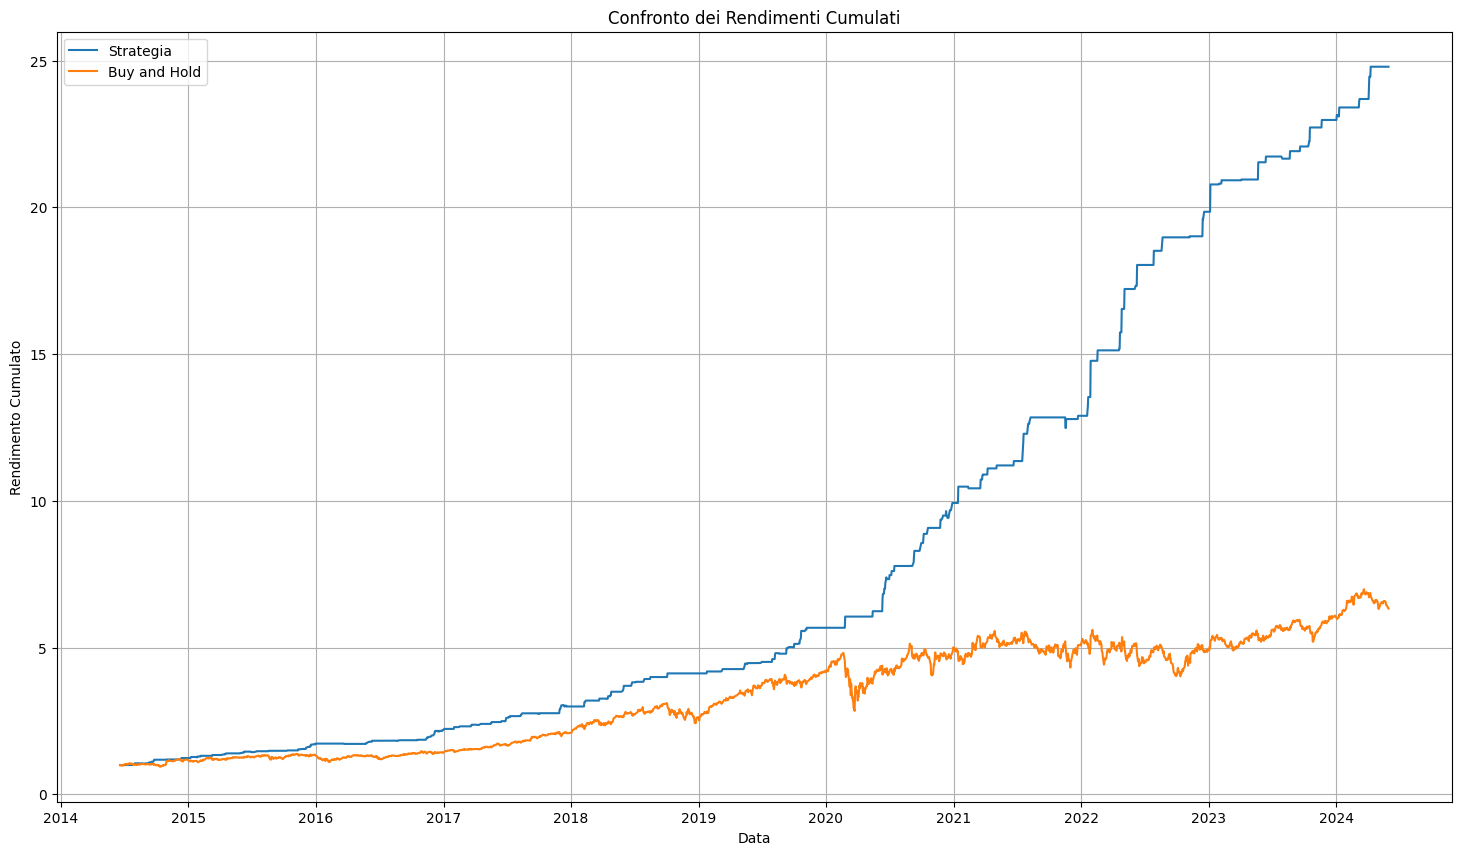

In [35]:
# Calcola i rendimenti cumulati delle due strategie # TODO: STRATEGIA DI CALCOLO DI CHATGPT
rendimento_cumulato_strategia = (1 + strategia_trading['Posizione'].diff() * strategia_trading['Chiusura aggiustata'].pct_change()).cumprod()
rendimento_cumulato_buy_and_hold = (1 + strategia_trading['Chiusura aggiustata'].pct_change()).cumprod()

# Crea un grafico
plt.figure(figsize=(18, 10))
plt.plot(rendimento_cumulato_strategia, label='Strategia')
plt.plot(rendimento_cumulato_buy_and_hold, label='Buy and Hold')
plt.title('Confronto dei Rendimenti Cumulati')
plt.xlabel('Data')
plt.ylabel('Rendimento Cumulato')
plt.legend()
plt.grid(True)
plt.show()

## CAPM

Arriviamo quindi alla sezione dedicata al Capital Asset Pricing Model.

Per prima cosa scarichiamo i dati mensili relativi al modello di Fama e French: in questo modo possiamo sfruttare i dati relativi ai tassi risk-free mensili.

In [37]:
# popoliamo un dataframe con i dati di fama e french mensili
fama_french_mensile = pd.DataFrame(gff.famaFrench3Factor(frequency='m'))
fama_french_mensile.rename({'date_ff_factors': 'Date'}, axis=1, inplace=True)
fama_french_mensile.set_index('Date', inplace = True)
fama_french_mensile = fama_french_mensile.loc[inizio: fine] # filtriamo per il periodo di interesse

fama_french_mensile = fama_french_mensile.tail(-2) # rimuovo le prime due righe per allinearlo al dataframe CAPM
fama_french_mensile

,Mkt-RF,SMB,HML,RF
Date,,,,
2014-07-31,-0.0204,-0.0429,0.0003,0.0000
2014-08-31,0.0424,0.0040,-0.0045,0.0000
2014-09-30,-0.0197,-0.0371,-0.0134,0.0000
2014-10-31,0.0252,0.0421,-0.0181,0.0000
2014-11-30,0.0255,-0.0206,-0.0309,0.0000
...,...,...,...,...
2023-12-31,0.0487,0.0634,0.0493,0.0043
2024-01-31,0.0070,-0.0509,-0.0238,0.0047
2024-02-29,0.0506,-0.0024,-0.0349,0.0042


Dopodiché scarichiamo i dati relativi al mercato (indice S&P500), ne calcoliamo il rendimento netto mensile e il premio di mercato.

In [38]:
# scarichiamo da yahoo finance i prezzi di chiusura dell'indice S&P500
sp500 = prendi_dati_titolo('^GSPC', inizio, fine)
sp500.drop(['Open','High','Low','Close','Volume'], axis=1, inplace=True)
sp500.rename(columns={'Adj Close': 'Chiusura aggiustata'}, inplace=True)

# ricampioniamo i prezzi su base mensile (prendendo l'ultimo giorno di ciascun mese)
sp500 = sp500.resample("ME").last()

sp500['Rendimento netto mensile'] = sp500['Chiusura aggiustata'].pct_change()
sp500.dropna(inplace=True)

sp500['Premio di mercato'] = sp500['Rendimento netto mensile'] - fama_french_mensile['RF']

sp500

,Chiusura aggiustata,Rendimento netto mensile,Premio di mercato
Date,,,
2014-07-31,1930.670044,-0.015080,-0.015080
2014-08-31,2003.369995,0.037655,0.037655
2014-09-30,1972.290039,-0.015514,-0.015514
2014-10-31,2018.050049,0.023201,0.023201
2014-11-30,2067.560059,0.024534,0.024534
...,...,...,...
2024-01-31,4845.649902,0.015896,0.011196
2024-02-29,5096.270020,0.051721,0.047521
2024-03-31,5254.350098,0.031019,0.026719


Andiamo poi a comporre un dataframe che raccoglie per ciascun titolo il prezzo di chiusura aggiustato, il rendimento netto mensile ed il premio di rischio.

In [39]:
dati_mensili_titoli = dataframe_completo.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume'], axis=1)
dati_mensili_titoli.rename(columns={'Adj Close': 'Chiusura aggiustata'}, inplace=True)

# trasformiamo le date in oggetti datetime facilmente manipolabili da pandas
dati_mensili_titoli.index = dati_mensili_titoli.index.set_levels(pd.to_datetime(dati_mensili_titoli.index.levels[1]), level=1)

# per ciascun ticker, ricampioniamo il dataframe su base mensile
dati_mensili_titoli = dati_mensili_titoli.groupby('Ticker').resample('ME', level=1).last()

# calcoliamo il rendimento netto mensile
dati_mensili_titoli['Rendimento netto mensile'] = dati_mensili_titoli.groupby('Ticker')['Chiusura aggiustata'].pct_change()
dati_mensili_titoli = dati_mensili_titoli.dropna()

dati_mensili_titoli['Premio di rischio'] = dati_mensili_titoli['Rendimento netto mensile'] - fama_french_mensile['RF']

dati_mensili_titoli

Chiusura aggiustata  Rendimento netto mensile  \
Ticker Date                                                        
AAPL   2014-07-31            21.140388                  0.028731   
       2014-08-31            22.778957                  0.077509   
       2014-09-30            22.390053                 -0.017073   
       2014-10-31            24.001245                  0.071960   
       2014-11-30            26.544863                  0.105979   
...                                ...                       ...   
WMT    2024-01-31            54.707005                  0.048208   
       2024-02-29            58.209579                  0.064024   
       2024-03-31            59.962444                  0.030113   
       2024-04-30            59.145275                 -0.013628   
       2024-05-31            64.889999                  0.097129   

                   Premio di rischio  
Ticker Date                           
AAPL   2014-07-31           0.028731  
       2014-08-31           0.077509  
       2014-09-30          -0.017073  
       2014-10-31           0.071960  
       2014-11-30           0.105979  
...                              ...  
WMT    2024-01-31           0.043508  
       2024-02-29           0.059824  
       2024-03-31           0.025813  
       2024-04-30          -0.018328  
       2024-05-31                NaN  

[714 rows x 3 columns]

Definiamo quindi una funzione per effettuare la regressione e stimare il modello.

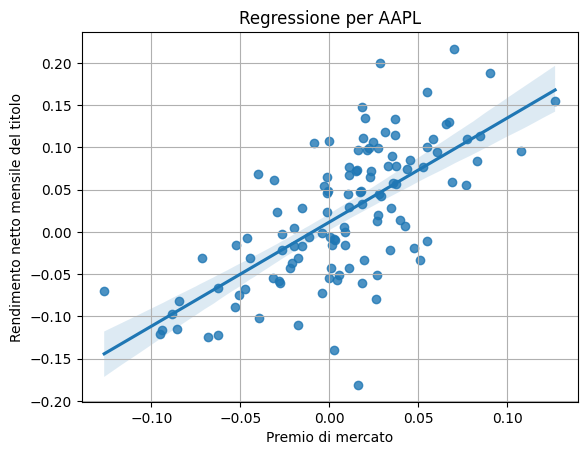

,coef,std err,t,P>|t|,[0.025,0.975]
const,0.0115,0.006,2.086,0.039,0.001,0.022
Premio di mercato,1.2332,0.123,9.994,0.000,0.989,1.478


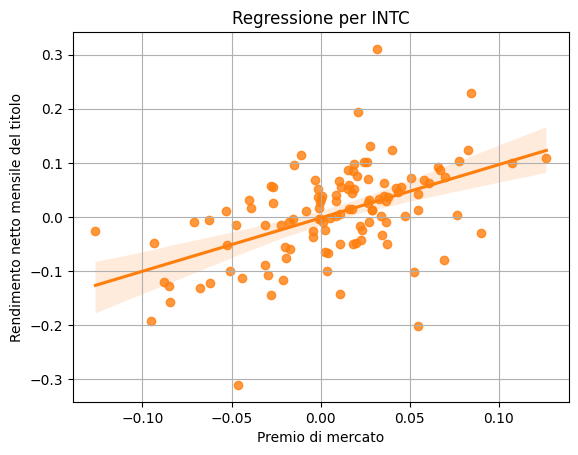

,coef,std err,t,P>|t|,[0.025,0.975]
const,-0.0018,0.007,-0.259,0.796,-0.016,0.012
Premio di mercato,0.9842,0.156,6.317,0.000,0.676,1.293


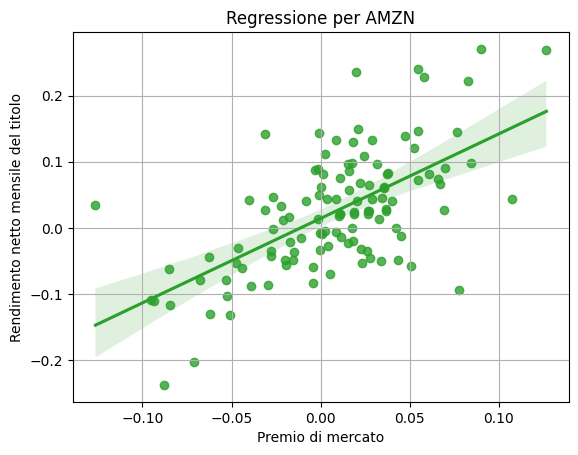

,coef,std err,t,P>|t|,[0.025,0.975]
const,0.0142,0.007,2.157,0.033,0.001,0.027
Premio di mercato,1.2768,0.147,8.667,0.000,0.985,1.569


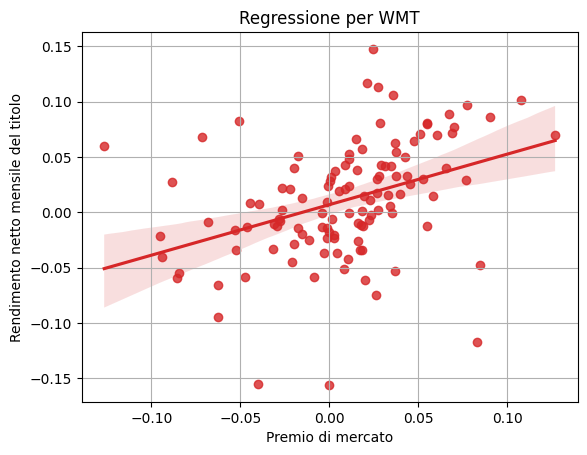

,coef,std err,t,P>|t|,[0.025,0.975]
const,0.0069,0.005,1.506,0.135,-0.002,0.016
Premio di mercato,0.4574,0.102,4.497,0.000,0.256,0.659


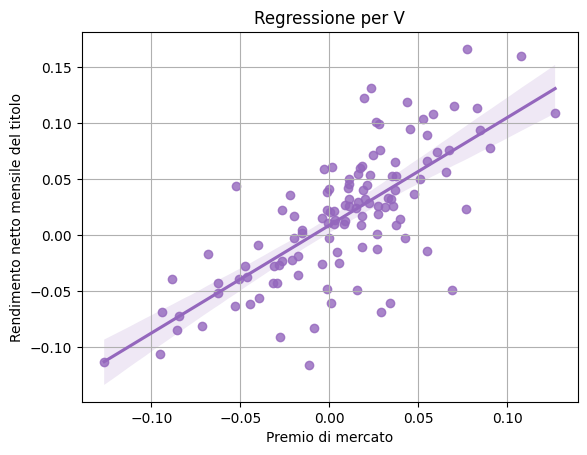

,coef,std err,t,P>|t|,[0.025,0.975]
const,0.0086,0.004,2.270,0.025,0.001,0.016
Premio di mercato,0.9626,0.085,11.385,0.000,0.795,1.130


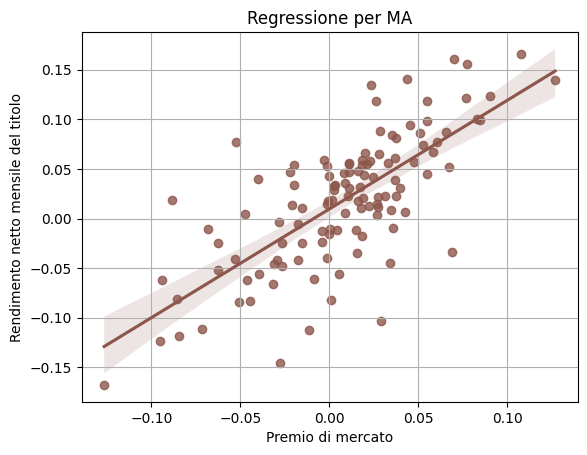

,coef,std err,t,P>|t|,[0.025,0.975]
const,0.0096,0.004,2.246,0.027,0.001,0.018
Premio di mercato,1.0964,0.095,11.492,0.000,0.907,1.285


In [40]:
def regressione_OLS(ticker, dati_mensili_titoli, dati_mensili_mercato, colore='blue'):
    dati_mensili_titoli = dati_mensili_titoli.dropna()
    dati_mensili_mercato = dati_mensili_mercato.dropna()
    merged_data = pd.merge(dati_mensili_titoli, dati_mensili_mercato, left_index=True, right_index=True)
    data_ticker = merged_data.loc[ticker]

    X = data_ticker['Premio di mercato']
    Y = data_ticker['Rendimento netto mensile_x'] # rendimento netto mensile del titolo
    X1 = sm.add_constant(X)
    model = sm.OLS(Y, X1)
    results = model.fit()

    plt.figure()
    sns.regplot(x='Premio di mercato', y='Rendimento netto mensile_x', data=data_ticker, color=colore)
    plt.grid(axis='both')
    plt.title(f'Regressione per {ticker}')
    plt.xlabel('Premio di mercato')
    plt.ylabel('Rendimento netto mensile del titolo')
    plt.show()

    html_output = '<h4>Esposizione al rischio di mercato per il titolo ' + f'{ticker}</h4>'
    html_output += results.summary().tables[1].as_html()
    html_output += '<br><br>'
    display_html(html_output, raw=True)
    
    return results.params['const'], results.params['Premio di mercato'], results.tvalues['const']

# Definiamo una lista per accumulare i risultati della regressione
parametri_capm = []
valori_t = []

for i, ticker in enumerate(tickers):
    colore = mappa_colori(i % 10)  # L'operazione modulo assicura che non superiamo l'indice massimo della mappa
    intercetta, beta, t_valore = regressione_OLS(ticker, dati_mensili_titoli, sp500, colore)
    parametri_capm.append([ticker, intercetta, beta])
    valori_t.append(t_valore)

Ricapitoliamo infine in un dataframe il coefficiente beta di ciascun titolo.

In [41]:
# Convertiamo la lista in un DataFrame
coefficienti_capm = pd.DataFrame(parametri_capm, columns=['Ticker', 'Intercetta', 'Beta']).set_index('Ticker')

def significativo(t):
    if abs(t) > 2:
        return 'si'
    else:
        return 'no'

# Aggiungi la colonna 'Significativo' al DataFrame coefficienti_capm
coefficienti_capm['Costante significativa?'] = [significativo(t) for t in valori_t]


coefficienti_capm

,Intercetta,Beta,Costante significativa?
Ticker,,,
AAPL,0.011535,1.233159,si
INTC,-0.001812,0.984189,no
AMZN,0.014242,1.276793,si
WMT,0.006868,0.457411,no
V,0.008603,0.962597,si
MA,0.009604,1.096412,si


Dalla stima del modello CAPM emerge che diversi titoli hanno costante significativa (t>2), a testimonianza dell'esistenza di ulteriori fattori di rischio oltre a quello di mercato.

Utilizziamo i valori beta calcolati in precedenza per calcolare il rendimento atteso annuo di ciascun titolo: per stimare il tasso risk-free utilizziamo l'attuale rendimento dei t-bill a un anno, mentre per stimare il rendimento del mercato utilizziamo una proiezione del rendimento dell'indice S&P500 a un anno (per fare ciò prendiamo il rendimento annuo medio avuto dall'indice dal 1980 ad oggi).

I dati dei t-bill provengono dalla banca dati "Federal Reserve Economic Data" (FRED), link: https://fred.stlouisfed.org/series/DGS1

In [42]:
file_path = os.path.join('DatiFinanziari', 'DGS1.csv')
tbill_1anno = pd.read_csv(file_path)
tbill_1anno['DATE'] = pd.to_datetime(tbill_1anno['DATE'])
tbill_1anno.set_index('DATE', inplace=True)
tbill_1anno['DGS1'] = pd.to_numeric(tbill_1anno['DGS1'], errors='coerce')
tbill_1anno['DGS1'] = tbill_1anno['DGS1'] / 100

stima_rf = tbill_1anno['DGS1'].loc[:fine].tail(1).iloc[0]

stima_rf # attuale tasso di interesse sui T-Bill a un anno

0.0518

In [43]:
tbill_1anno = tbill_1anno.resample('YE').last()

tbill_1anno

,DGS1
DATE,
1962-12-31,0.0305
1963-12-31,0.0383
1964-12-31,0.0399
1965-12-31,0.0496
1966-12-31,0.0500
...,...
2020-12-31,0.0010
2021-12-31,0.0039
2022-12-31,0.0473


In [44]:
sp500_storico = prendi_dati_titolo('^GSPC', dt.datetime(1980, 1, 2), fine)
sp500_storico.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
sp500_storico = sp500_storico.resample("YE").last()
sp500_storico['Rendimento netto annuo'] = sp500_storico['Adj Close'].pct_change()
sp500_storico.dropna(inplace=True)

sp500_storico

,Adj Close,Rendimento netto annuo
Date,,
1981-12-31,122.550003,-0.097304
1982-12-31,140.639999,0.147613
1983-12-31,164.929993,0.172710
1984-12-31,167.240005,0.014006
1985-12-31,211.279999,0.263334
1986-12-31,242.169998,0.146204
1987-12-31,247.080002,0.020275
1988-12-31,277.720001,0.124008
1989-12-31,353.399994,0.272505


In [45]:
tbill_1anno = tbill_1anno.loc[sp500_storico.index] # allinea le date di sp500 e t-bill
sp500_storico['Premio di mercato'] = sp500_storico['Rendimento netto annuo'] - tbill_1anno['DGS1']
stima_premio_mercato = sp500_storico['Premio di mercato'].mean()

stima_premio_mercato # media premio di mercato degli ultimi 44 anni

0.05831420353931221

In [46]:
rendimenti_attesi = stima_rf + coefficienti_capm['Beta'] * stima_premio_mercato
rendimenti_attesi = rendimenti_attesi.rename('Rendimento atteso annuo')

rendimenti_attesi

Ticker
AAPL    0.123711
INTC    0.109192
AMZN    0.126255
WMT     0.078474
V       0.107933
MA      0.115736
Name: Rendimento atteso annuo, dtype: float64

Ora calcoliamo l'esposizione dei vari titoli ai fattori di Fama e French. <br>
Sfruttiamo i dati scaricati in precedenza.

In [47]:
def regressione_fama_french(ticker, dati_mensili_titoli, dati_fama_french):
    # Step 1: Pulire i dati
    dati_mensili_titoli = dati_mensili_titoli.dropna()
    dati_fama_french = dati_fama_french.dropna()
    dati_fama_french = dati_fama_french.rename(columns={'Mkt-RF': 'MKT'})
    
    # Step 2: Unire i dati basandosi sulle date
    merged_data = dati_mensili_titoli.join(dati_fama_french)
    merged_data.rename(columns={'Premio di rischio': 'premio_rischio'}, inplace=True)

    # Step 3: Filtrare i dati per il ticker specificato
    dati = merged_data.loc[ticker]
    
    results = smf.ols(formula = 'premio_rischio ~ MKT + SMB + HML', data = dati).fit()
    
    html_output = '<h4>Esposizione ai fattori Fama French per il titolo ' + f'{ticker}</h4>'
    html_output += results.summary().tables[1].as_html()
    html_output += '<br><br>'
    display_html(html_output, raw=True)
    
    # Restituire i coefficienti del modello e i valori t
    return results.params, results.tvalues

parametri_fama_french = []
valori_t = []

for ticker in tickers:
    coefficients, t_values = regressione_fama_french(ticker, dati_mensili_titoli, fama_french_mensile)
    parametri_fama_french.append([ticker] + list(coefficients))
    valori_t.append([ticker] + list(t_values))

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.0074,0.005,1.405,0.163,-0.003,0.018
MKT,1.2330,0.117,10.504,0.000,1.000,1.466
SMB,-0.2218,0.195,-1.135,0.259,-0.609,0.165
HML,-0.5634,0.137,-4.102,0.000,-0.835,-0.291


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.0040,0.007,-0.557,0.579,-0.018,0.010
MKT,0.9527,0.159,5.988,0.000,0.638,1.268
SMB,-0.0802,0.265,-0.303,0.763,-0.605,0.445
HML,0.0452,0.186,0.243,0.809,-0.324,0.414


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.0088,0.006,1.559,0.122,-0.002,0.020
MKT,1.3138,0.126,10.433,0.000,1.064,1.563
SMB,-0.3186,0.210,-1.520,0.131,-0.734,0.097
HML,-0.9690,0.147,-6.578,0.000,-1.261,-0.677


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.0033,0.004,0.752,0.454,-0.005,0.012
MKT,0.5207,0.098,5.292,0.000,0.326,0.716
SMB,-0.5321,0.164,-3.249,0.002,-0.857,-0.208
HML,-0.1899,0.115,-1.650,0.102,-0.418,0.038


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.0050,0.004,1.328,0.187,-0.002,0.012
MKT,0.9913,0.084,11.802,0.000,0.825,1.158
SMB,-0.4658,0.140,-3.331,0.001,-0.743,-0.189
HML,-0.0942,0.098,-0.959,0.340,-0.289,0.100


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.0062,0.004,1.439,0.153,-0.002,0.015
MKT,1.1173,0.096,11.652,0.000,0.927,1.307
SMB,-0.4348,0.160,-2.723,0.007,-0.751,-0.119
HML,0.0349,0.112,0.311,0.756,-0.187,0.257


In [48]:
coefficienti_fama_french = pd.DataFrame(parametri_fama_french, columns=['Ticker', 'Intercetta', 'MKT', 'SMB', 'HML'])
coefficienti_fama_french.set_index('Ticker', inplace=True)

valori_t_fama_french = pd.DataFrame(valori_t, columns=['Ticker', 'Intercetta_t', 'MKT_t', 'SMB_t', 'HML_t'])
valori_t_fama_french.set_index('Ticker', inplace=True)

coefficienti_fama_french['Costante significativa?'] = [significativo(t) for t in valori_t_fama_french['Intercetta_t']]
coefficienti_fama_french['MKT significativo?'] = [significativo(t) for t in valori_t_fama_french['MKT_t']]
coefficienti_fama_french['SMB significativo?'] = [significativo(t) for t in valori_t_fama_french['SMB_t']]
coefficienti_fama_french['HML significativo?'] = [significativo(t) for t in valori_t_fama_french['HML_t']]

coefficienti_fama_french

,Intercetta,MKT,SMB,HML,Costante significativa?,MKT significativo?,SMB significativo?,HML significativo?
Ticker,,,,,,,,
AAPL,0.007413,1.233031,-0.221757,-0.563415,no,si,no,si
INTC,-0.003979,0.952713,-0.080198,0.045194,no,si,no,no
AMZN,0.008821,1.313817,-0.318636,-0.969033,no,si,no,si
WMT,0.003323,0.520686,-0.532130,-0.189875,no,si,si,no
V,0.005012,0.991254,-0.465787,-0.094233,no,si,si,no
MA,0.006200,1.117294,-0.434791,0.034918,no,si,si,no


## Ottimizzazione di portafoglio



In [49]:
num_mesi = 108
num_portafogli = 100000

np.random.seed(42)
pesi = np.random.random(size=(num_portafogli, len(tickers)))
pesi = pesi / np.sum(pesi, axis=1)[:, np.newaxis]

pesi

array([[0.12619616, 0.32033016, 0.24663533, 0.20170978, 0.05256834,
        0.05256022],
       [0.01801633, 0.26866992, 0.18645344, 0.21962946, 0.00638488,
        0.30084597],
       [0.37179051, 0.09483616, 0.08120775, 0.08191322, 0.13588249,
        0.23436986],
       ...,
       [0.05021462, 0.27167712, 0.11629452, 0.07722281, 0.28143659,
        0.20315434],
       [0.11578566, 0.20315036, 0.15698162, 0.00964943, 0.19625364,
        0.3181793 ],
       [0.19375968, 0.15611637, 0.1111844 , 0.16522393, 0.2217342 ,
        0.15198143]])

In [50]:
rendimenti_netti_mensili = prezzi_chiusura_giornalieri.resample('ME').last().pct_change()
rendimenti_netti_mensili.dropna(inplace=True)

rendimenti_netti_mensili

Ticker,AAPL,INTC,AMZN,WMT,V,MA
Date,,,,,,
2014-07-31,0.028731,0.096763,-0.036302,-0.019848,0.001424,0.010704
2014-08-31,0.077509,0.037247,0.083229,0.032854,0.009075,0.022387
2014-09-30,-0.017073,-0.002864,-0.048962,0.012848,0.004000,-0.024931
2014-10-31,0.071960,-0.023262,-0.052661,-0.002616,0.131509,0.134657
2014-11-30,0.105979,0.102447,0.108623,0.147765,0.071479,0.042269
...,...,...,...,...,...,...
2024-01-31,-0.042227,-0.142686,0.021456,0.048208,0.049587,0.054930
2024-02-29,-0.018543,0.002233,0.138918,0.064024,0.036255,0.056831
2024-03-31,-0.051286,0.026016,0.020480,0.030113,-0.012596,0.014344


In [51]:
rendimenti_medi_annualizzati = rendimenti_netti_mensili.iloc[:num_mesi].mean() * 12
rendimenti_medi_annualizzati.name = 'Rendimento netto medio annualizzato'

rendimenti_medi_annualizzati

Ticker
AAPL    0.290865
INTC    0.075254
AMZN    0.283420
WMT     0.121548
V       0.196606
MA      0.221581
Name: Rendimento netto medio annualizzato, dtype: float64

In [52]:
matrice_covarianza = rendimenti_netti_mensili.iloc[:num_mesi].cov() * 12

matrice_covarianza

Ticker,AAPL,INTC,AMZN,WMT,V,MA
Ticker,,,,,,
AAPL,0.080455,0.031617,0.050531,0.017886,0.031972,0.036724
INTC,0.031617,0.076128,0.027169,0.008493,0.025599,0.026367
AMZN,0.050531,0.027169,0.103216,0.012652,0.030637,0.032158
WMT,0.017886,0.008493,0.012652,0.035246,0.011195,0.009638
V,0.031972,0.025599,0.030637,0.011195,0.043204,0.044516
MA,0.036724,0.026367,0.032158,0.009638,0.044516,0.055412


In [53]:
# moltiplichiamo (prodotto tra matrici) i pesi per i rendimenti medi annualizzati
rendimenti_portafogli = np.dot(pesi, rendimenti_medi_annualizzati)

volatilita_portafogli = []
for i in range(0, len(pesi)):
    # formula per la volatilità (deviazione standard)
    volatilita_portafogli.append(np.sqrt(np.dot(pesi[i].T,
                                                np.dot(matrice_covarianza, pesi[i]))))
volatilita_portafogli = np.array(volatilita_portafogli)
sharpe_ratio_portafogli = rendimenti_portafogli / volatilita_portafogli

risultati_portafogli = pd.DataFrame({'Rendimenti': rendimenti_portafogli,
                                 'Volatilità': volatilita_portafogli,
                                 'Sharpe Ratio': sharpe_ratio_portafogli})

risultati_portafogli

,Rendimenti,Volatilità,Sharpe Ratio
0,0.177213,0.187928,0.942979
1,0.172916,0.176882,0.977582
2,0.226897,0.201174,1.127867
3,0.223409,0.203135,1.099805
4,0.168697,0.177810,0.948746
...,...,...,...
99995,0.200115,0.191740,1.043675
99996,0.203484,0.178781,1.138170
99997,0.177744,0.186846,0.951287
99998,0.203718,0.198947,1.023977


In [54]:
punti_da_visualizzare = 100
volatilita_frontiera_efficiente = []
indici_da_skippare = []

rendimenti_frontiera_efficiente = np.linspace(risultati_portafogli['Rendimenti'].min(),
                                              risultati_portafogli['Rendimenti'].max(),
                                              punti_da_visualizzare)
rendimenti_frontiera_efficiente = np.round(rendimenti_frontiera_efficiente, 2)    
rendimenti_portafogli = np.round(rendimenti_portafogli, 2)

for i in range(punti_da_visualizzare):
    if rendimenti_frontiera_efficiente[i] not in rendimenti_portafogli:
        indici_da_skippare.append(i)
        continue
    indice_trovato = np.where(rendimenti_portafogli == rendimenti_frontiera_efficiente[i])
    volatilita_frontiera_efficiente.append(np.min(volatilita_portafogli[indice_trovato]))
    
rendimenti_frontiera_efficiente = np.delete(rendimenti_frontiera_efficiente, indici_da_skippare)

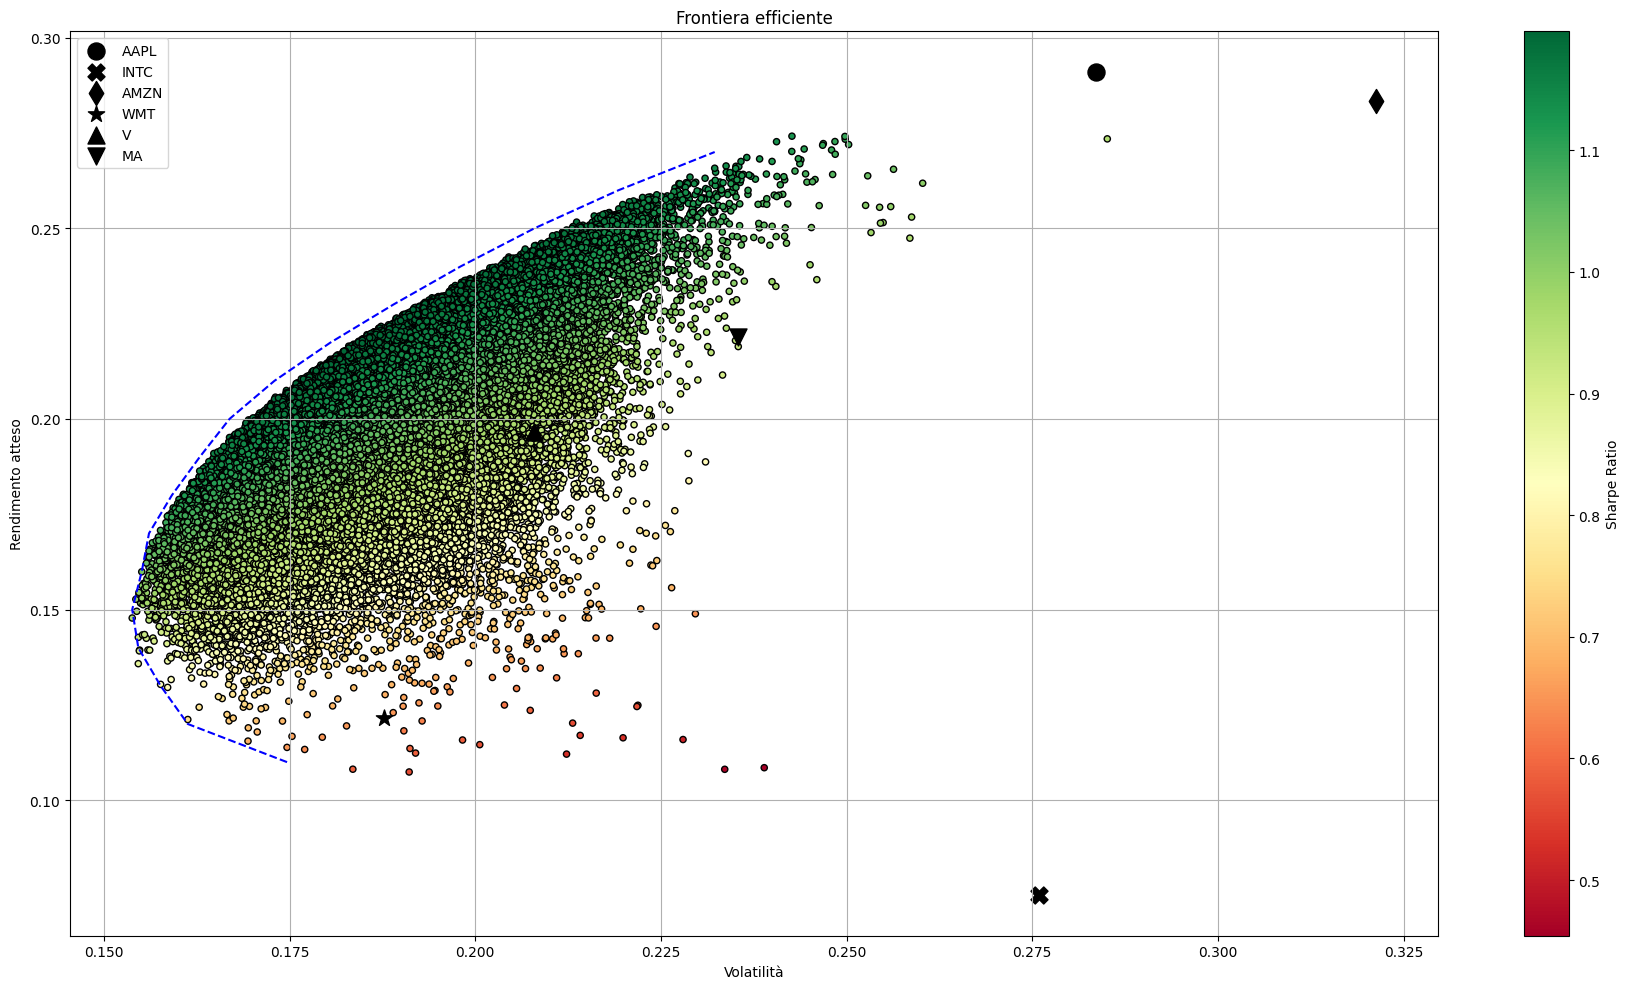

In [55]:
simboli = ['o', 'X', 'd', '*', '^', 'v']

fig, ax = plt.subplots(figsize=(18, 10))
risultati_portafogli.plot(kind='scatter', x='Volatilità',
                      y='Rendimenti', c='Sharpe Ratio',
                      cmap='RdYlGn', edgecolors='black', 
                      ax=ax)
ax.set(xlabel='Volatilità', 
       ylabel='Rendimento atteso', 
       title='Frontiera efficiente')
ax.plot(volatilita_frontiera_efficiente, rendimenti_frontiera_efficiente, 'b--')
for i, ticker in enumerate(tickers):
    ax.scatter(x=np.sqrt(matrice_covarianza.iloc[i, i]),
               y=rendimenti_medi_annualizzati.iloc[i],
               marker=simboli[i],
               s=150,
               color='black',
               label=ticker)
ax.legend()

plt.tight_layout()
plt.grid()
plt.show()

In [63]:
massimo_sr_sim = np.argmax(risultati_portafogli['Sharpe Ratio'])
portafoglio_max_sr_sim = risultati_portafogli.loc[massimo_sr_sim]

print('Portafoglio ottimale in termini di media-varianza')
print('\nPerformance')
for index, value in portafoglio_max_sr_sim.items():
    if index == 'Sharpe Ratio':
        print(f'{index}: {value:.2f} ', end="", flush=True)
    else:
        print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\n\nWeights')
for x, y in zip(tickers, pesi[np.argmax(risultati_portafogli['Sharpe Ratio'])]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Portafoglio ottimale in termini di media-varianza

Performance
Rendimenti: 22.21% Volatilità: 18.54% Sharpe Ratio: 1.20 

Weights
AAPL: 24.50% INTC: 0.11% AMZN: 17.85% WMT: 24.13% V: 12.88% MA: 20.54% 

In [69]:
rendimenti = 100 * portafoglio_max_sr_sim['Rendimenti']
volatilita = 100 * portafoglio_max_sr_sim['Volatilità']
sharpe_ratio = portafoglio_max_sr_sim['Sharpe Ratio']

# Creare un dizionario per le performance
performance_data = {
    'Valore': [f'{rendimenti:.2f}%', f'{volatilita:.2f}%', f'{sharpe_ratio:.2f}']
}

# Creare un DataFrame per le performance con la metrica come indice
performance_df = pd.DataFrame(performance_data, index=['Rendimenti', 'Volatilità', 'Sharpe Ratio'])

# Creare un dizionario per i pesi
weights_data = {
    'Peso': [f'{100*y:.2f}%' for y in pesi[massimo_sr_sim]]
}

# Creare un DataFrame per i pesi con il ticker come indice
weights_df = pd.DataFrame(weights_data, index=tickers)

display_html('<h4>Portafoglio ottimale in termini di media-varianza</h4><br>', raw=True)
display(performance_df)
display(weights_df)

Portafoglio ottimale in termini di media-varianza

,Valore
Rendimenti,22.21%
Volatilità,18.54%
Sharpe Ratio,1.20


,Peso
AAPL,24.50%
INTC,0.11%
AMZN,17.85%
WMT,24.13%
V,12.88%
MA,20.54%
